# PROJEKT 2  Predykcja zanieczyszczenia PMx 
# KRZYSZTOF KOWALSKI 407142
Zadanie polega na przeprowadzeniu analizy i predykcji szeregów czasowych dotyczących poziomu pyłu zawieszonego przy użyciu modelu XGBoost. Pył PM10 i PM2.5 to drobne cząstki stałe lub ciekłe zawieszone w powietrzu, których średnica wynosi odpowiednio 10 lub mniej i 2,5 mikrometra lub mniej.

Zanieczyszczenie powietrza tymi cząsteczkami stanowi istotny problem dla zdrowia publicznego, ponieważ może przenikać głęboko do płuc i układu krwionośnego, co ma negatywny wpływ na zdrowie. Predykcja zawartości PMx w powietrzu pozwoli na lepsze planowanie i informowanie ludności o potencjalnych zagrożeniu.

## Część 1: Przygotowanie danych i inżynieria cech (20 punktów)

### 1. Tworzenie cech (15 punktów)
Utwórz cechy (features) w oknach czasowych oraz cechy oparte na opóźnieniach wartości pyłu PM2.5 w celu uwzględnienia historii w predykcji. 

Dodatkowo, wykorzystaj informacje z datatime do tworzenia dodatkowych cech, takich jak dzień tygodnia, miesiąc, rok itp

Uzasadnij swój wybór.

Czy jest możliwe uwzględnienienie czynnika przestrzennego w tworzeniu cech? 

#### Wczytanie danych

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import STL
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import TimeSeriesSplit

Po zapoznaniu sie z wygladem danych w excelu zdecydowano na wcztanie sie ich w taki sposob aby kolumnami byly stacje pomiarowe natomiast indeksem data pomiaru.

In [7]:
data = pd.read_excel('2019_PM25_1g.xlsx', skiprows = 5)
data = data.melt(id_vars=["Kod stanowiska"], var_name="station_code", value_name="PM25").rename(columns = {'Kod stanowiska':'Data', 'station_code':'Nazwa Stacji'}) 
data['Nazwa Stacji'] = data['Nazwa Stacji'].str[:-9]
data

Data  Nazwa Stacji      PM25
0      2019-01-01 01:00:00  DsDusznikMOB  33.40530
1      2019-01-01 02:00:00  DsDusznikMOB  13.80280
2      2019-01-01 03:00:00  DsDusznikMOB   9.94056
3      2019-01-01 04:00:00  DsDusznikMOB   6.75889
4      2019-01-01 05:00:00  DsDusznikMOB   7.88722
...                    ...           ...       ...
551875 2019-12-31 20:00:00  ZpSzczPils02  19.16890
551876 2019-12-31 21:00:00  ZpSzczPils02  19.71360
551877 2019-12-31 22:00:00  ZpSzczPils02  20.24390
551878 2019-12-31 23:00:00  ZpSzczPils02  24.74170
551879 2020-01-01 00:00:00  ZpSzczPils02  36.85750

[551880 rows x 3 columns]

W celu lepszej ekslopracji i poznania zbioru stwierdzono, ze nalezy dane uzupelnic o lokalizacje stacji. Informacje te są łatwo dostępne pod adresem https://powietrze.gios.gov.pl/pjp/archives/.

In [9]:
stacje = pd.read_excel('kody_stacji.xlsx')
stacje

Nr       Kod stacji Kod międzynarodowy  \
0        1         DsBialka                NaN   
1        2       DsBielGrot                NaN   
2        3  DsBogatFrancMOB            PL0602A   
3        4        DsBogChop            PL0315A   
4        5  DsBogZatonieMob            PL0576A   
...    ...              ...                ...   
1090  1091     ZpSzczPilsud            PL0249A   
1091  1092  ZpSzczWSSEEnerg                NaN   
1092  1093  ZpSzczWSSESped6                NaN   
1093  1094   ZpWalWalczWSSE                NaN   
1094  1095     ZpWiduBulRyb            PL0182A   

                        Nazwa stacji  \
0                             Białka   
1     Bielawa - ul. Grota Roweckiego   
2                    Bogatynia Mobil   
3                Bogatynia - Chopina   
4                  Bogatynia - Mobil   
...                              ...   
1090      Szczecin, ul. Piłsudskiego   
1091                     Energetyków   
1092                     Spedytorska   
1093                           Wałcz   
1094                       Widuchowa   

     Stary Kod stacji \n(o ile inny od aktualnego) Data uruchomienia  \
0                                              NaN        1990-01-03   
1                                              NaN        1994-01-02   
2                                       DsBogatMob        2015-01-01   
3                                              NaN        1996-01-01   
4                                              NaN        2012-01-01   
...                                            ...               ...   
1090                   ZpSzczecin002, ZpSzczPils02        2004-12-31   
1091                                           NaN        1992-01-01   
1092                                           NaN        1992-01-01   
1093                                           NaN        1992-01-01   
1094                            ZpGryfWiduchowa003        2003-01-01   

     Data zamknięcia     Typ stacji  Typ obszaru            Rodzaj stacji  \
0         2005-12-31    przemysłowa   podmiejski  kontenerowa stacjonarna   
1         2003-12-31            tło      miejski                w budynku   
2         2015-12-31            tło      miejski                  mobilna   
3         2013-12-31    przemysłowa      miejski  kontenerowa stacjonarna   
4         2012-12-31    przemysłowa      miejski                  mobilna   
...              ...            ...          ...                      ...   
1090             NaT  komunikacyjna      miejski  kontenerowa stacjonarna   
1091      2003-12-31  komunikacyjna      miejski                w budynku   
1092      2004-01-01            tło      miejski  kontenerowa stacjonarna   
1093      2005-01-01            tło      miejski                w budynku   
1094             NaT            tło  pozamiejski  kontenerowa stacjonarna   

             Województwo Miejscowość                   Adres  WGS84 φ N  \
0           DOLNOŚLĄSKIE      Białka                     NaN  51.197783   
1           DOLNOŚLĄSKIE     Bielawa  ul. Grota Roweckiego 6  50.682510   
2           DOLNOŚLĄSKIE   Bogatynia     ul. Francuska/Kręta  50.940998   
3           DOLNOŚLĄSKIE   Bogatynia          ul. Chopina 35  50.905856   
4           DOLNOŚLĄSKIE   Bogatynia    ul. Konrada, Zatonie  50.943245   
...                  ...         ...                     ...        ...   
1090  ZACHODNIOPOMORSKIE    Szczecin      ul. Piłsudskiego 1  53.432169   
1091  ZACHODNIOPOMORSKIE    Szczecin       ul. Energetyków 2  53.420475   
1092  ZACHODNIOPOMORSKIE    Szczecin       ul. Spedytorska 6  53.415043   
1093  ZACHODNIOPOMORSKIE       Wałcz         ul. Bydgoska 86  53.263667   
1094  ZACHODNIOPOMORSKIE   Widuchowa  ul. Bulwary Rybackie 1  53.122325   

      WGS84 λ E  
0     16.117390  
1     16.617348  
2     14.916790  
3     14.967175  
4     14.913327  
...         ...  
1090  14.553900  
1091  14.561934  
1092  14.555347  
1093  16.492596  
1094  14.382245  

[1095 rows x 15 co

Ponieważ niektóre z naz stacji zmieniły nazwę, należało je odpowiednio zamienić.

In [11]:
data.rename(columns = {"LbNaleczow": "LbNaleczAlMa", "MzKonJezMos": "MzKonJezWieMOB", "PdSuwPulaskp": "PdSuwPulask2", "PmGdaLeczk08": "PmGdaLeczkow", "ZpSzczAndr01": "ZpSzczAndrze", "ZpSzczPils02": "ZpSzczPilsud"}, inplace = True)
data = data.merge(stacje, left_on = 'Nazwa Stacji', right_on = 'Kod stacji', how = 'inner')
data = data[['Data', 'Nazwa stacji', 'PM25', 'Typ obszaru', 'Województwo', 'WGS84 φ N', 'WGS84 λ E']]
data

Data             Nazwa stacji      PM25 Typ obszaru  \
0      2019-01-01 01:00:00           Duszniki-Zdrój  33.40530     miejski   
1      2019-01-01 02:00:00           Duszniki-Zdrój  13.80280     miejski   
2      2019-01-01 03:00:00           Duszniki-Zdrój   9.94056     miejski   
3      2019-01-01 04:00:00           Duszniki-Zdrój   6.75889     miejski   
4      2019-01-01 05:00:00           Duszniki-Zdrój   7.88722     miejski   
...                    ...                      ...       ...         ...   
499315 2019-12-31 20:00:00  Szczecin_Budzysza Wosia  15.59590     miejski   
499316 2019-12-31 21:00:00  Szczecin_Budzysza Wosia  13.18250     miejski   
499317 2019-12-31 22:00:00  Szczecin_Budzysza Wosia  14.37640     miejski   
499318 2019-12-31 23:00:00  Szczecin_Budzysza Wosia  17.79410     miejski   
499319 2020-01-01 00:00:00  Szczecin_Budzysza Wosia  20.86120     miejski   

               Województwo  WGS84 φ N  WGS84 λ E  
0             DOLNOŚLĄSKIE  50.402645  16.393319  
1             DOLNOŚLĄSKIE  50.402645  16.393319  
2             DOLNOŚLĄSKIE  50.402645  16.393319  
3             DOLNOŚLĄSKIE  50.402645  16.393319  
4             DOLNOŚLĄSKIE  50.402645  16.393319  
...                    ...        ...        ...  
499315  ZACHODNIOPOMORSKIE  53.446761  14.507294  
499316  ZACHODNIOPOMORSKIE  53.446761  14.507294  
499317  ZACHODNIOPOMORSKIE  53.446761  14.507294  
499318  ZACHODNIOPOMORSKIE  53.446761  14.507294  
499319  ZACHODNIOPOMORSKIE  53.446761  14.507294  

[499320 rows x 7 columns]

#### EDA

Zaczęto od sprawdzenia ilości wartości brakujących w każdej z kolumn. Widoczne są wartości brakujące w kolumnie związanej z wielkością zanieczyszczenia. W celu lepszej eksploracji tych wartości sprawdzono jak prezentują się dane w tej kolumnie w zależności od stacji z której pochodzi informacja.

In [14]:
for col in data.columns:
    print(f'W kolumnie {col} znajduje się {np.sum(data[col].isna())} co stanowi {round(100 * np.sum(data[col].isna()) / len(data[col]), 2)}% wszystkich wartości.')

W kolumnie Data znajduje się 0 co stanowi 0.0% wszystkich wartości.
W kolumnie Nazwa stacji znajduje się 0 co stanowi 0.0% wszystkich wartości.
W kolumnie PM25 znajduje się 18660 co stanowi 3.74% wszystkich wartości.
W kolumnie Typ obszaru znajduje się 0 co stanowi 0.0% wszystkich wartości.
W kolumnie Województwo znajduje się 0 co stanowi 0.0% wszystkich wartości.
W kolumnie WGS84 φ N znajduje się 0 co stanowi 0.0% wszystkich wartości.
W kolumnie WGS84 λ E znajduje się 0 co stanowi 0.0% wszystkich wartości.


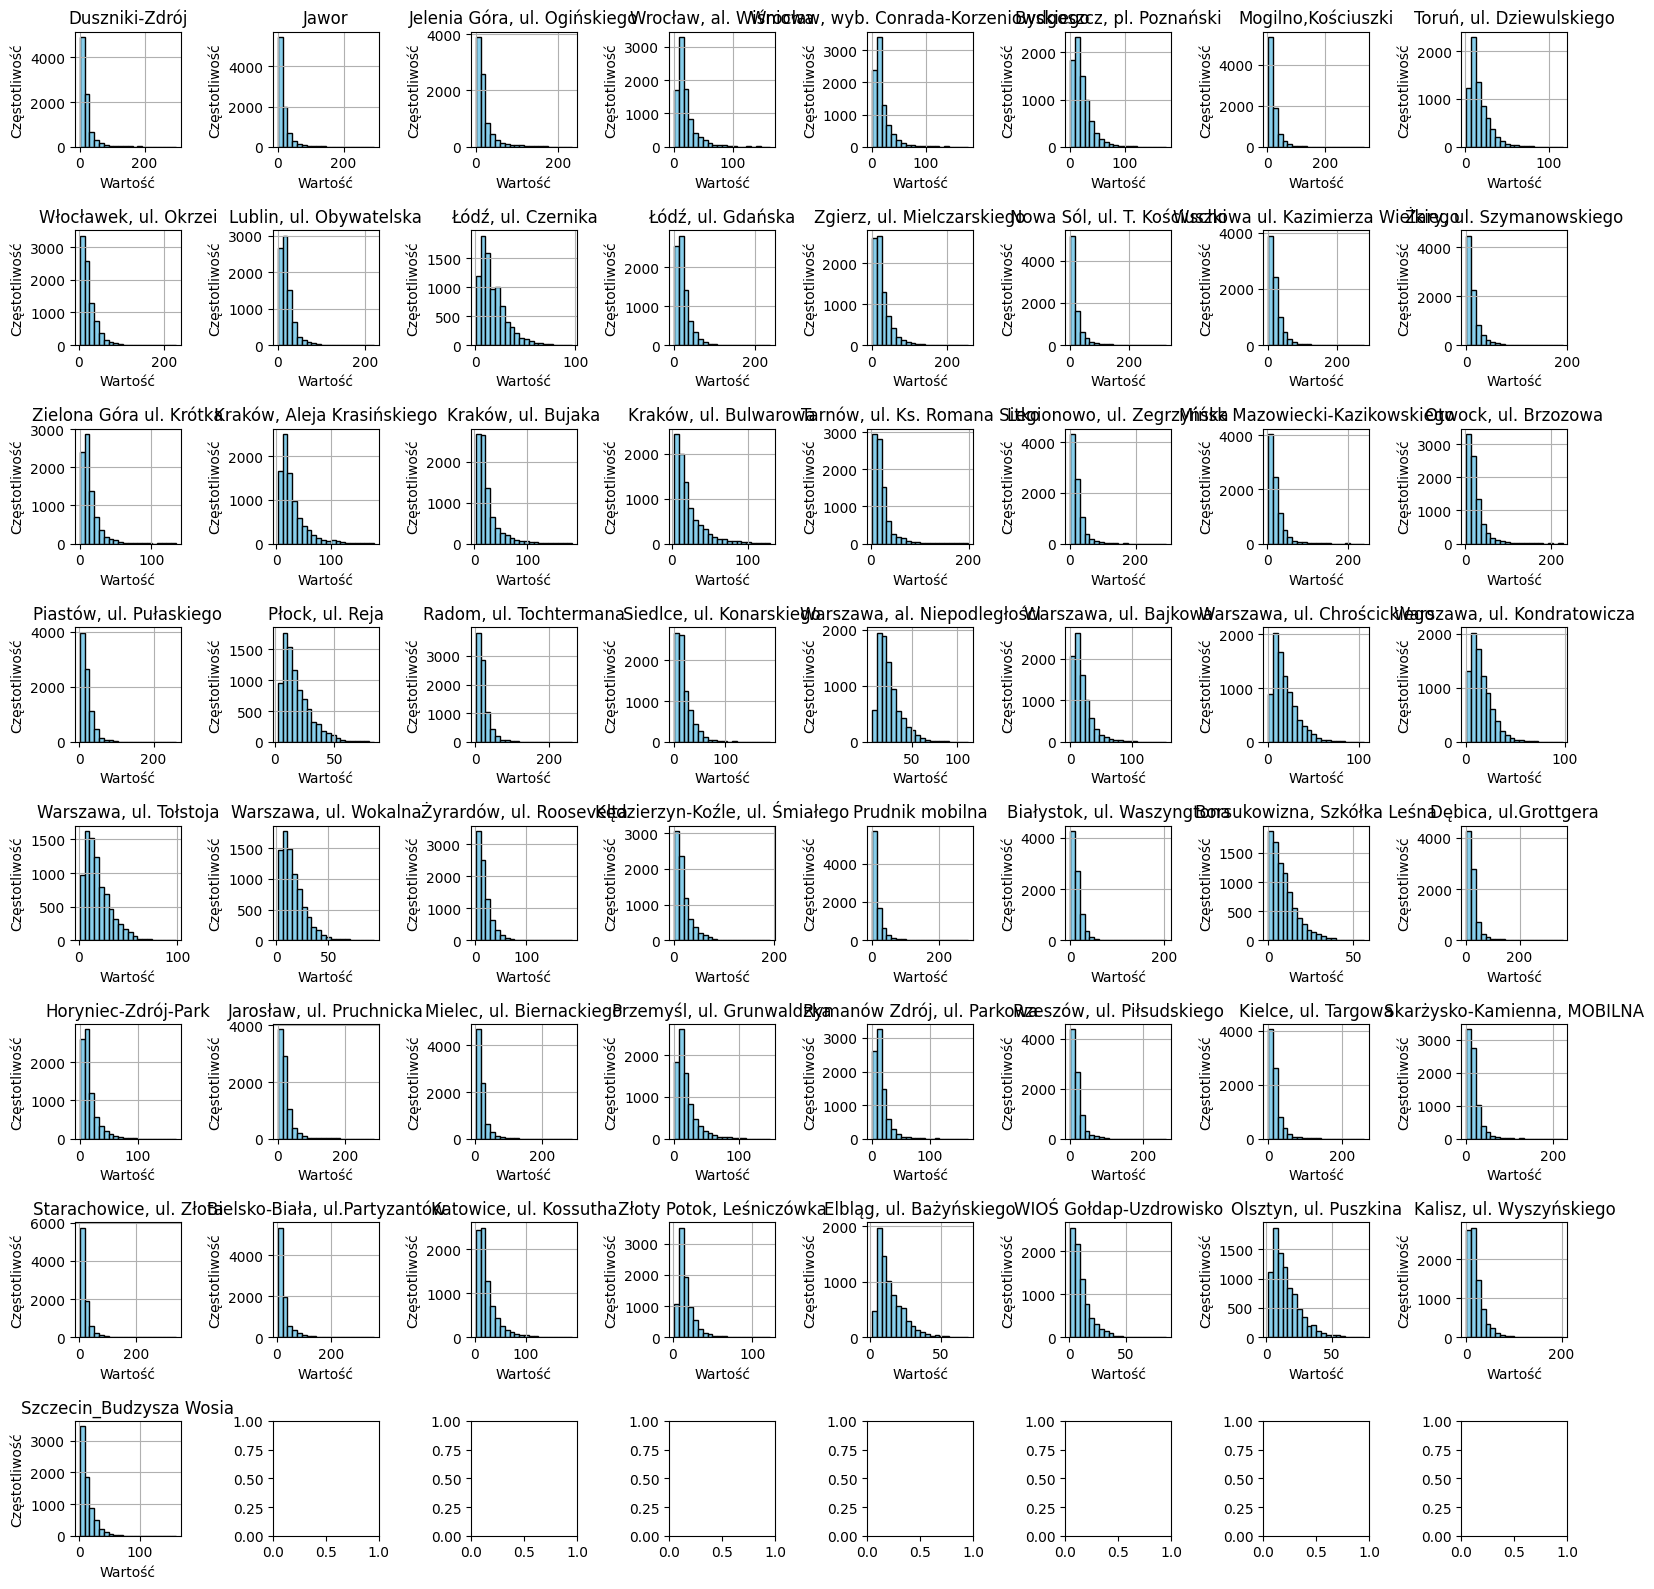

In [15]:
fig, axs = plt.subplots(8, 8, figsize=(16, 16))

for i, col in enumerate(data['Nazwa stacji'].unique()):
    ax = axs[i // 8, i % 8]
    ax.hist(data[data['Nazwa stacji'] == col]['PM25'], bins = 20, color = 'skyblue', edgecolor = 'black')
    ax.set_title(col)
    ax.set_xlabel('Wartość')
    ax.set_ylabel('Częstotliwość')
    ax.grid()

plt.tight_layout()

Stacje posiadają podobny rozkład częstotliwości wystąpień. Jest to rozkład nie przypominający rozkładu normalnego.

In [17]:
brakujace_wartosci = data[data['PM25'].isnull()].groupby('Nazwa stacji')['PM25'].size()
brakujace_wartosci

Nazwa stacji
Białystok, ul. Waszyngtona                217
Bielsko-Biała, ul.Partyzantów              20
Borsukowizna, Szkółka Leśna                44
Bydgoszcz, pl. Poznański                  849
Duszniki-Zdrój                            114
Dębica, ul.Grottgera                      311
Elbląg, ul. Bażyńskiego                  1055
Horyniec-Zdrój-Park                       673
Jarosław, ul. Pruchnicka                   43
Jawor                                      49
Jelenia Góra, ul. Ogińskiego              262
Kalisz, ul. Wyszyńskiego                  212
Katowice, ul. Kossutha                    569
Kielce, ul. Targowa                       419
Kraków, Aleja Krasińskiego                 30
Kraków, ul. Bujaka                        100
Kraków, ul. Bulwarowa                      77
Kędzierzyn-Koźle, ul. Śmiałego            590
Legionowo, ul. Zegrzyńska                 123
Lublin, ul. Obywatelska                   348
Mielec, ul. Biernackiego                  383
Mińsk Mazowiecki-Kazi

Wyróżniają się stacje posiadające większą ilość wartości brakujących niż inne. Może to wynikać z innych częstotliwości próbkowania niż co godzinę, chwilowej awarii lub wyłączenia stacji lub pózniejszym pojawieniu się stacji niż badany okres.

Stwierdzono, że odpowiednim uzupełnieniem wartości brakujących będzie wybranie średnie z tej samej daty dla stacji znajdujących się w tym samym województwie.

In [20]:
data['PM25'] = data['PM25'].fillna(data.groupby(['Data', 'Województwo'])['PM25'].transform('mean'))
brakujace_wartosci = data[data['PM25'].isnull()].groupby('Nazwa stacji')['PM25'].size()
brakujace_wartosci

Nazwa stacji
Białystok, ul. Waszyngtona           7
Borsukowizna, Szkółka Leśna          7
Bydgoszcz, pl. Poznański             1
Kalisz, ul. Wyszyńskiego           212
Kielce, ul. Targowa                  1
Kędzierzyn-Koźle, ul. Śmiałego       1
Legionowo, ul. Zegrzyńska            1
Lublin, ul. Obywatelska            348
Mińsk Mazowiecki-Kazikowskiego       1
Mogilno,Kościuszki                   1
Otwock, ul. Brzozowa                 1
Piastów, ul. Pułaskiego              1
Prudnik mobilna                      1
Płock, ul. Reja                      1
Radom, ul. Tochtermana               1
Siedlce, ul. Konarskiego             1
Skarżysko-Kamienna, MOBILNA          1
Starachowice, ul. Złota              1
Szczecin_Budzysza Wosia           1620
Toruń, ul. Dziewulskiego             1
Warszawa, al. Niepodległości         1
Warszawa, ul. Bajkowa                1
Warszawa, ul. Chrościckiego          1
Warszawa, ul. Kondratowicza          1
Warszawa, ul. Tołstoja               1
Warszawa, ul

Dalej pozostały wartości brakujące które są jedyne w województwie - ich wartości uzupełniono poprzez średnią dla wszystkich stacji z tej samej data.

Pozostałe pojedyncze wartości uzupełniono poprzez interpolację.

Po tych zabiegach w zbiorze nie było już wartości brakujących.

In [22]:
data.loc[data['Nazwa stacji'] == 'Kalisz, ul. Wyszyńskiego', 'PM25'] = data['PM25'].fillna(data.groupby(data['Data'])['PM25'].transform('mean'))
data.loc[data['Nazwa stacji'] == 'Lublin, ul. Obywatelska', 'PM25'] = data['PM25'].fillna(data.groupby(data['Data'])['PM25'].transform('mean'))
data.loc[data['Nazwa stacji'] == 'Szczecin_Budzysza Wosia', 'PM25'] = data['PM25'].fillna(data.groupby(data['Data'])['PM25'].transform('mean'))
data['PM25'] = data['PM25'].interpolate()
brakujace_wartosci = data[data['PM25'].isnull()].groupby('Nazwa stacji')['PM25'].size()
brakujace_wartosci

Series([], Name: PM25, dtype: int64)

Ustawiono indeks danych jako kolumnę zawierającą datę i godzinę pomiaru.

In [24]:
data.set_index('Data', inplace=True)
data

Nazwa stacji      PM25 Typ obszaru  \
Data                                                                 
2019-01-01 01:00:00           Duszniki-Zdrój  33.40530     miejski   
2019-01-01 02:00:00           Duszniki-Zdrój  13.80280     miejski   
2019-01-01 03:00:00           Duszniki-Zdrój   9.94056     miejski   
2019-01-01 04:00:00           Duszniki-Zdrój   6.75889     miejski   
2019-01-01 05:00:00           Duszniki-Zdrój   7.88722     miejski   
...                                      ...       ...         ...   
2019-12-31 20:00:00  Szczecin_Budzysza Wosia  15.59590     miejski   
2019-12-31 21:00:00  Szczecin_Budzysza Wosia  13.18250     miejski   
2019-12-31 22:00:00  Szczecin_Budzysza Wosia  14.37640     miejski   
2019-12-31 23:00:00  Szczecin_Budzysza Wosia  17.79410     miejski   
2020-01-01 00:00:00  Szczecin_Budzysza Wosia  20.86120     miejski   

                            Województwo  WGS84 φ N  WGS84 λ E  
Data                                                           
2019-01-01 01:00:00        DOLNOŚLĄSKIE  50.402645  16.393319  
2019-01-01 02:00:00        DOLNOŚLĄSKIE  50.402645  16.393319  
2019-01-01 03:00:00        DOLNOŚLĄSKIE  50.402645  16.393319  
2019-01-01 04:00:00        DOLNOŚLĄSKIE  50.402645  16.393319  
2019-01-01 05:00:00        DOLNOŚLĄSKIE  50.402645  16.393319  
...                                 ...        ...        ...  
2019-12-31 20:00:00  ZACHODNIOPOMORSKIE  53.446761  14.507294  
2019-12-31 21:00:00  ZACHODNIOPOMORSKIE  53.446761  14.507294  
2019-12-31 22:00:00  ZACHODNIOPOMORSKIE  53.446761  14.507294  
2019-12-31 23:00:00  ZACHODNIOPOMORSKIE  53.446761  14.507294  
2020-01-01 00:00:00  ZACHODNIOPOMORSKIE  53.446761  14.507294  

[499320 rows x 6 columns]

Stworzono podzbiór zawierający dane zgrupowane dziennie (w celu lepszej czytelności wykresów). Wartość każdego dnia jest średnią wartością z danego dnia.

In [26]:
daily_avg_pm25 = data.groupby(['Nazwa stacji', pd.Grouper(freq='D')])['PM25'].mean().reset_index()
daily_avg_pm25

Nazwa stacji       Data       PM25
0      Białystok, ul. Waszyngtona 2019-01-01  16.913043
1      Białystok, ul. Waszyngtona 2019-01-02   6.041667
2      Białystok, ul. Waszyngtona 2019-01-03   3.687500
3      Białystok, ul. Waszyngtona 2019-01-04  11.833333
4      Białystok, ul. Waszyngtona 2019-01-05  10.833333
...                           ...        ...        ...
20857    Żyrardów, ul. Roosevelta 2019-12-28   6.722500
20858    Żyrardów, ul. Roosevelta 2019-12-29  16.902917
20859    Żyrardów, ul. Roosevelta 2019-12-30  22.192083
20860    Żyrardów, ul. Roosevelta 2019-12-31   9.006250
20861    Żyrardów, ul. Roosevelta 2020-01-01   8.010000

[20862 rows x 3 columns]

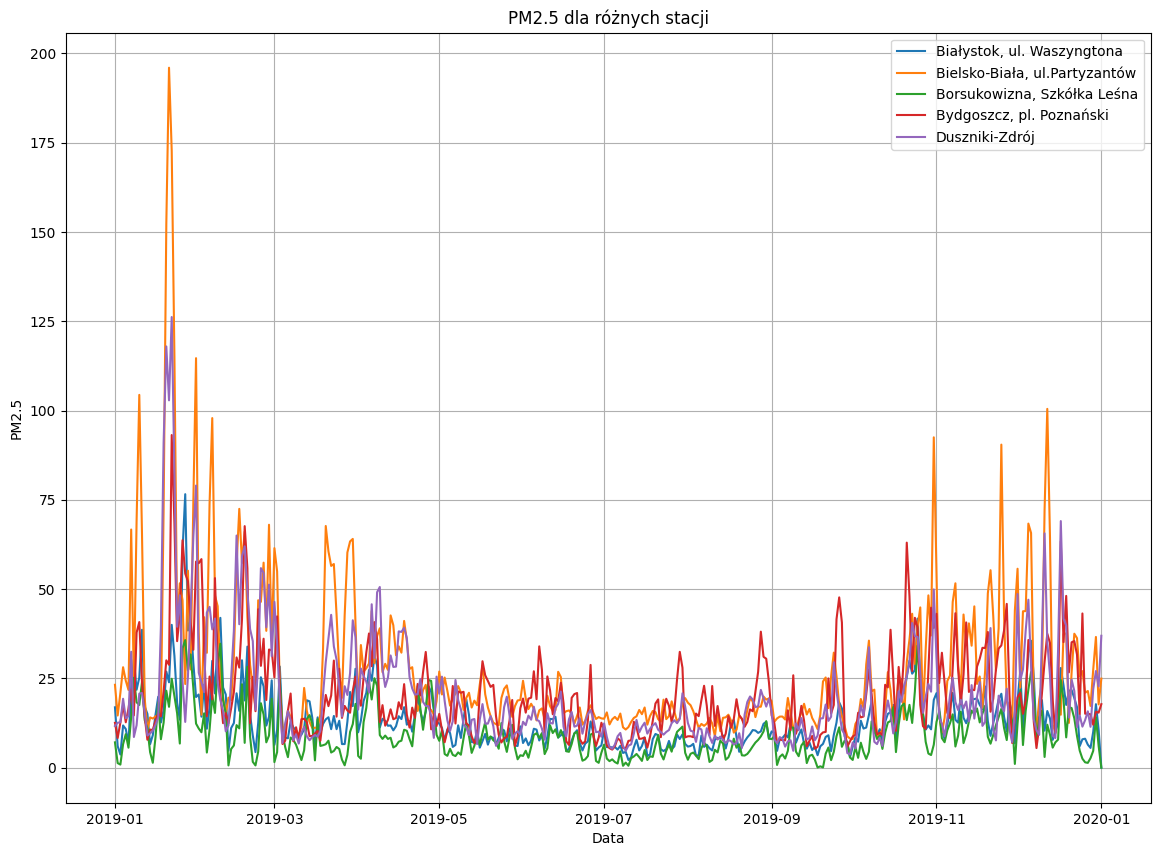

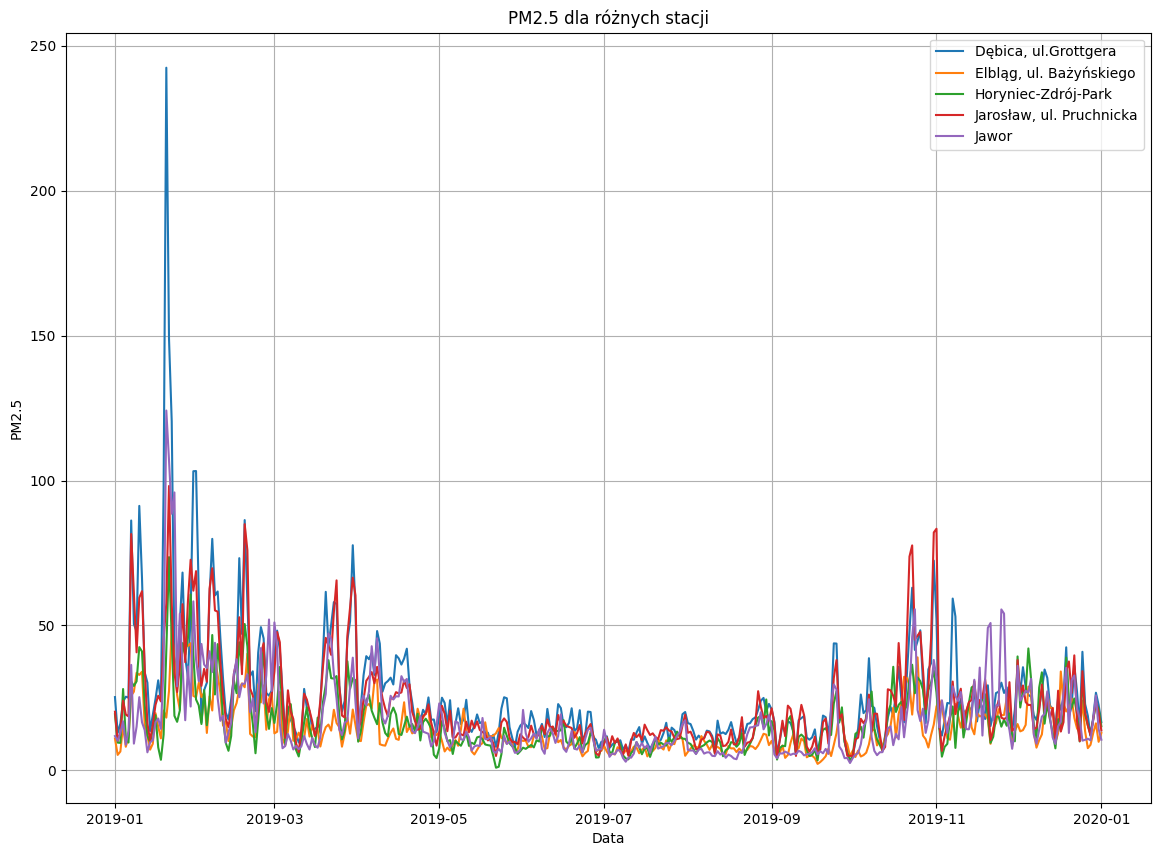

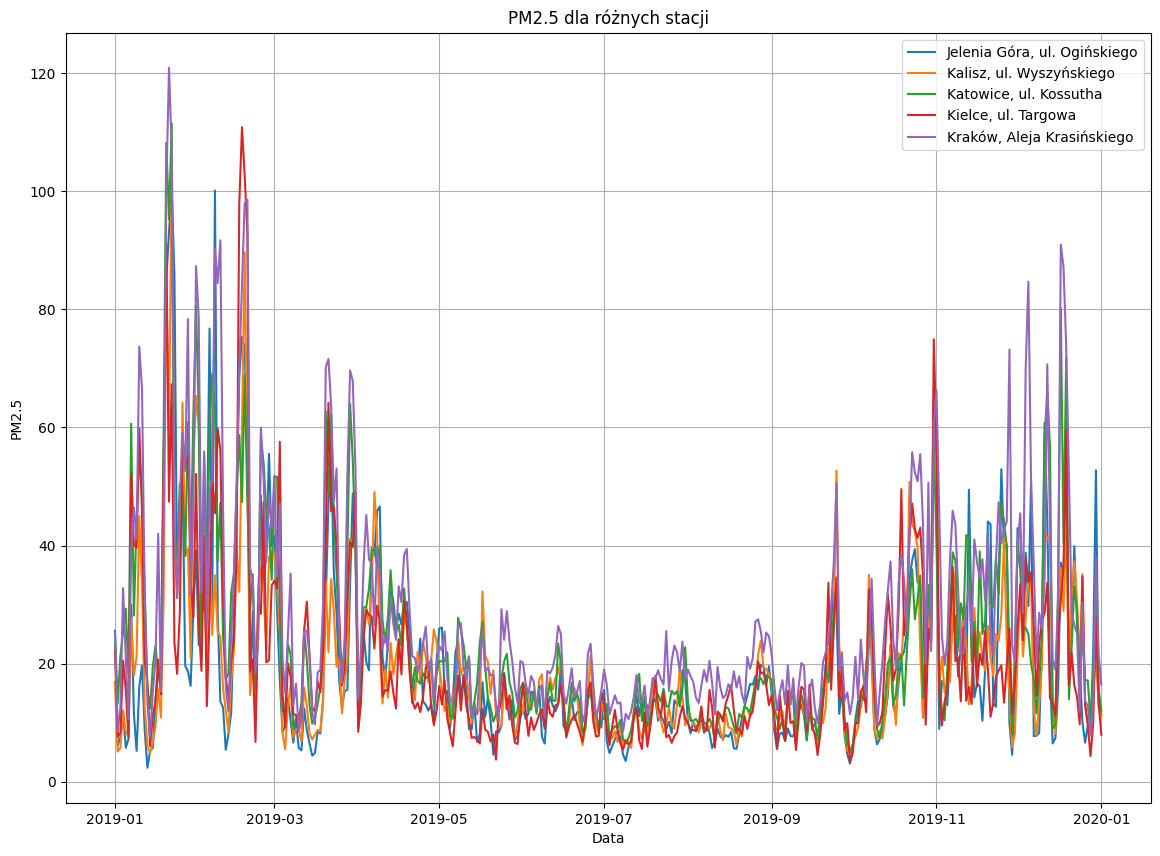

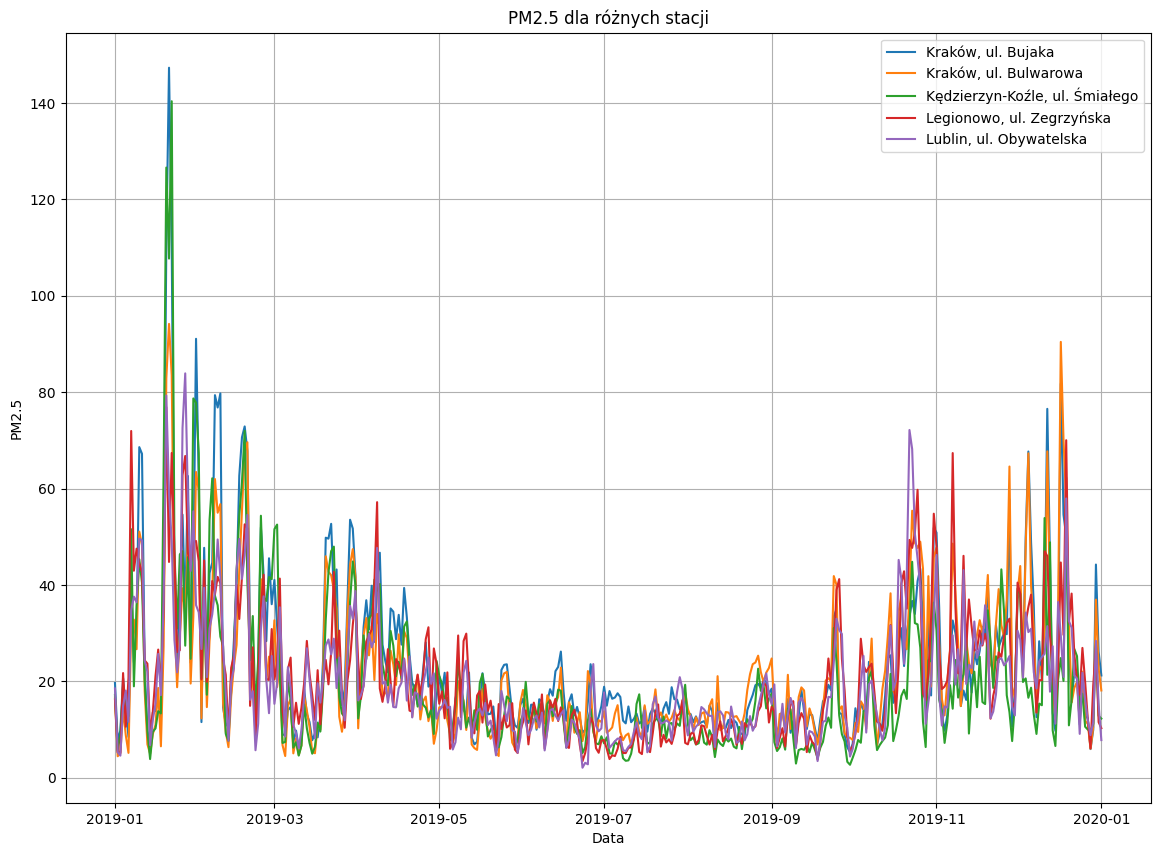

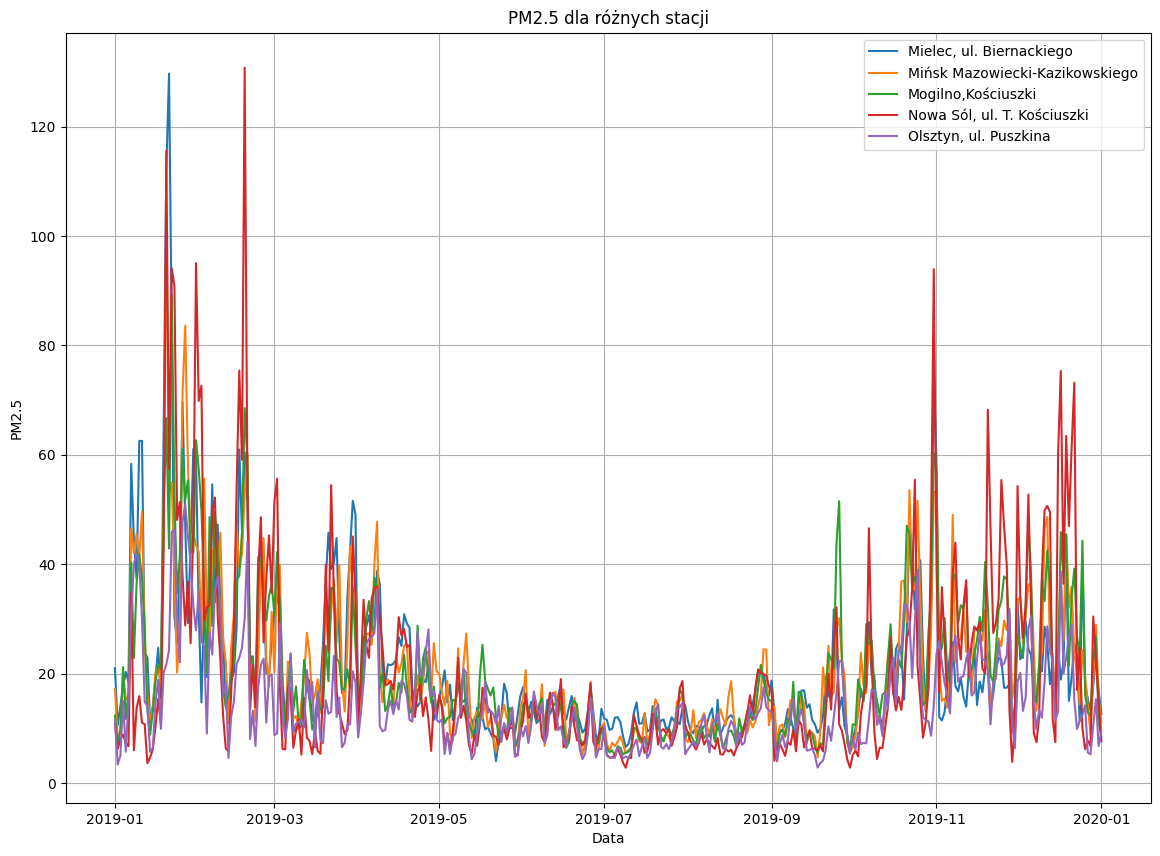

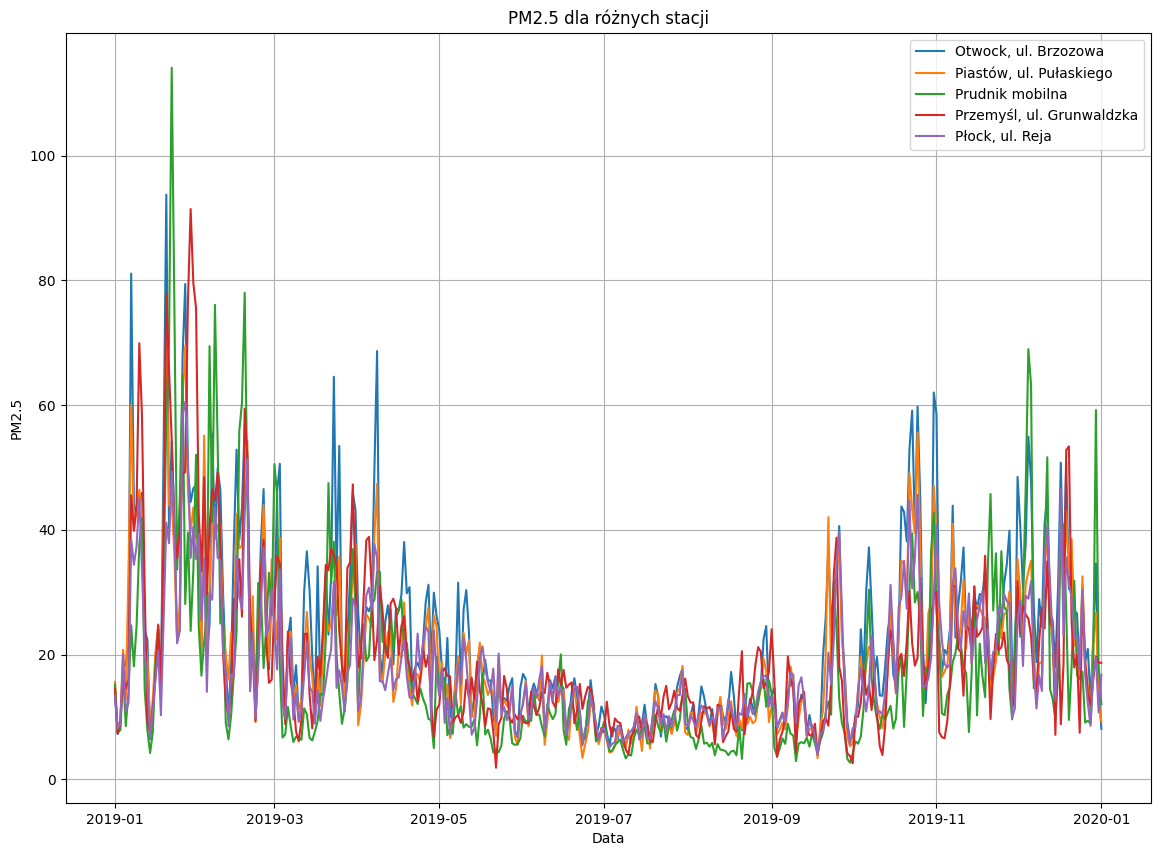

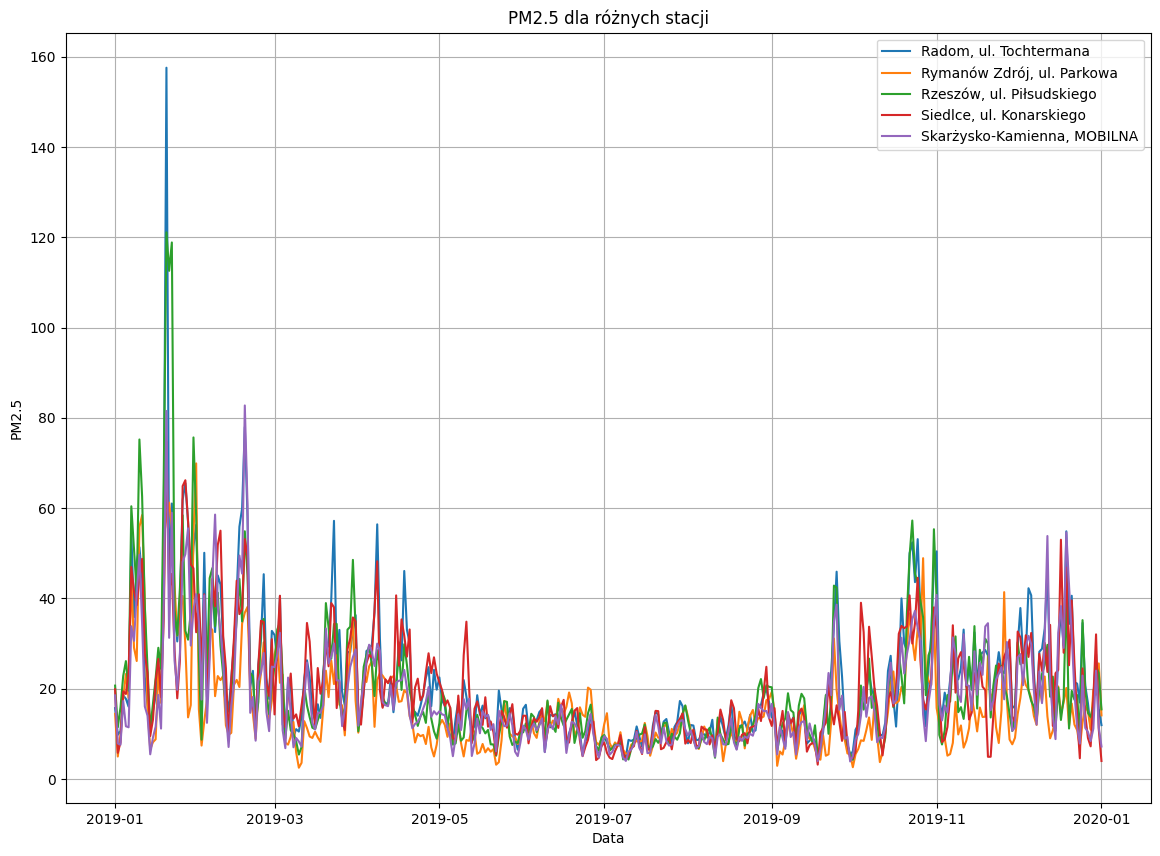

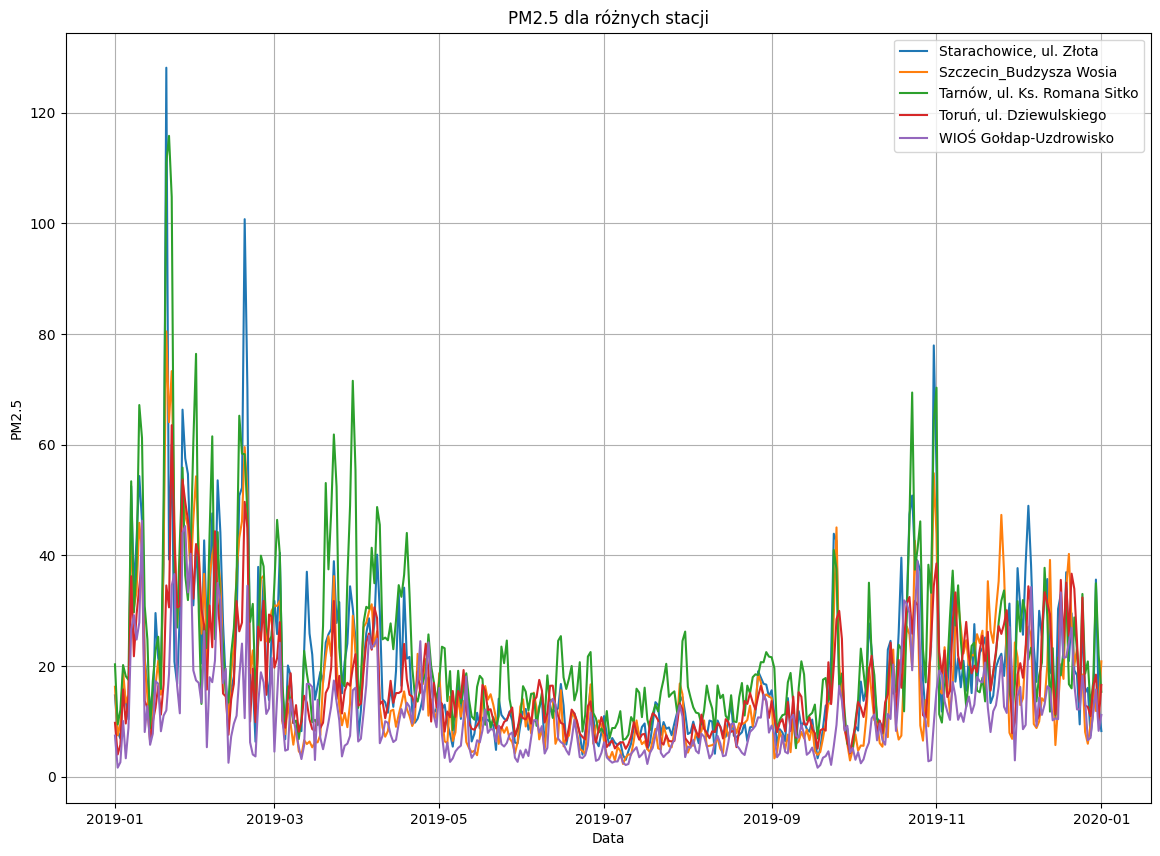

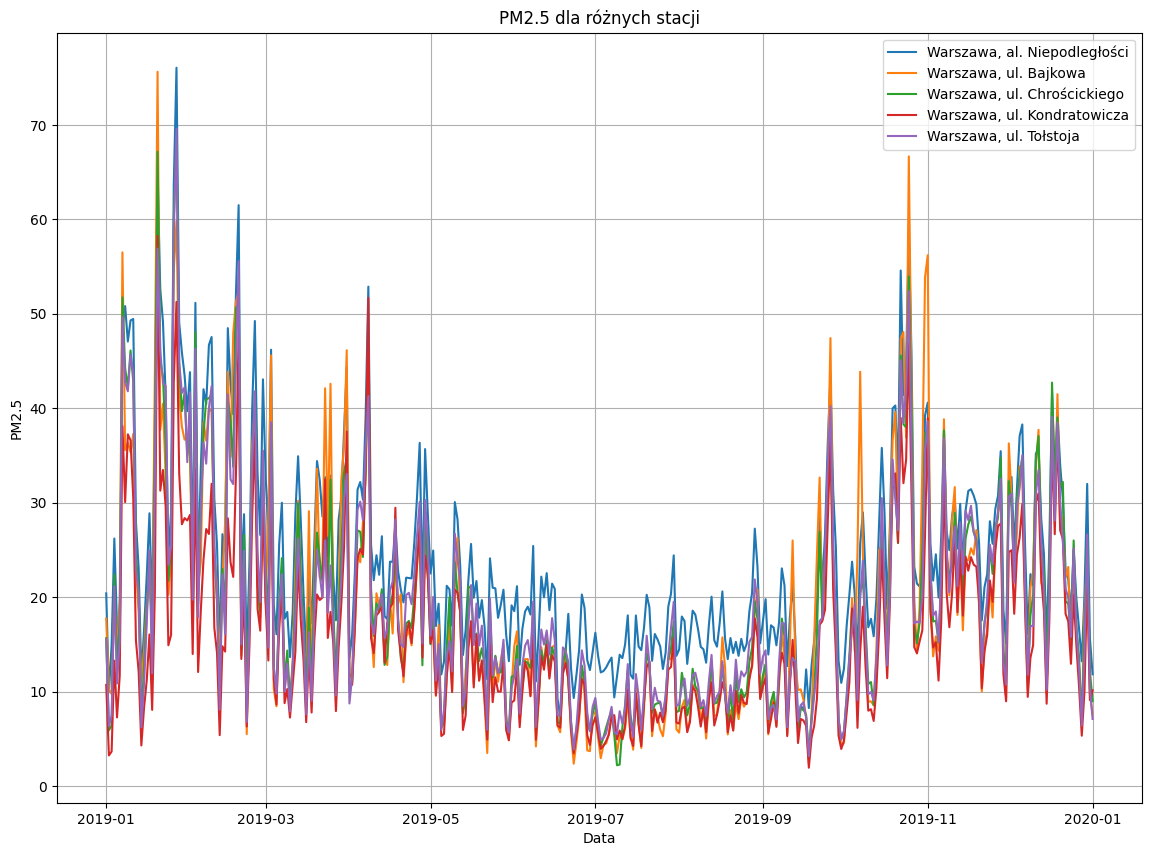

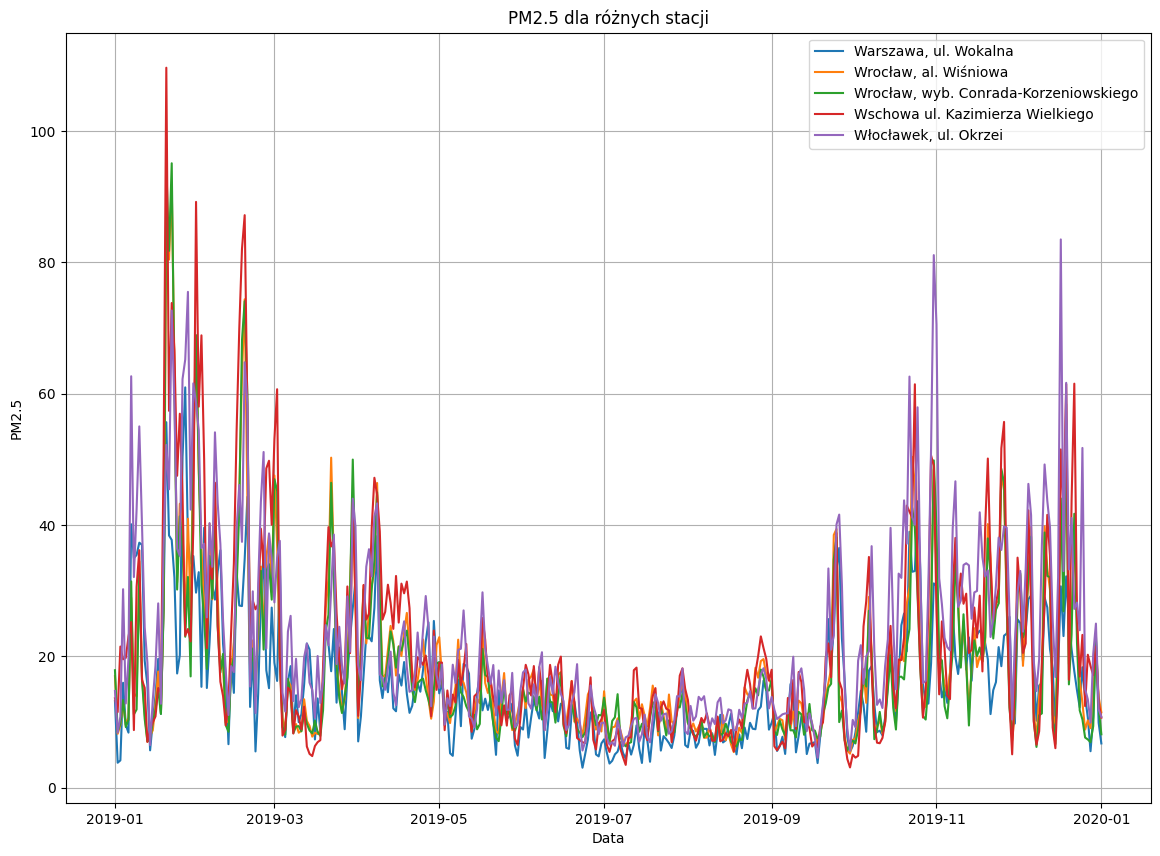

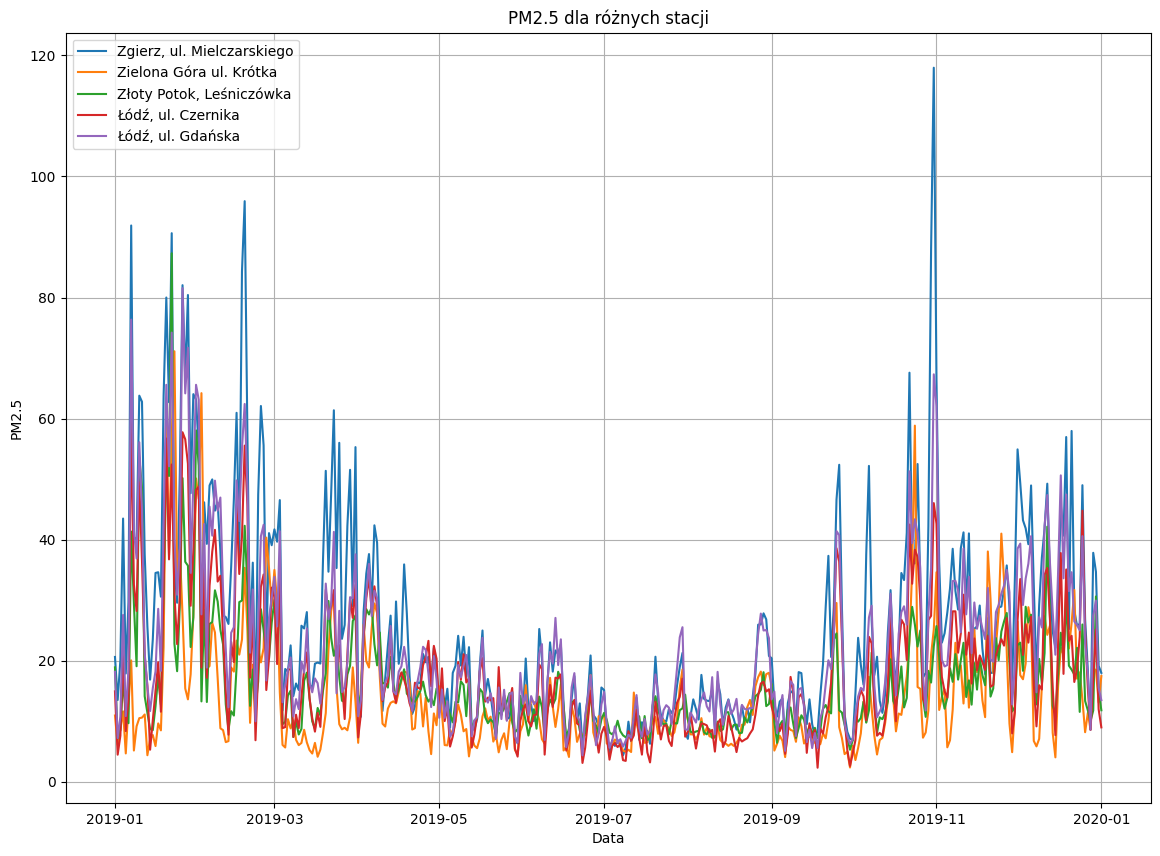

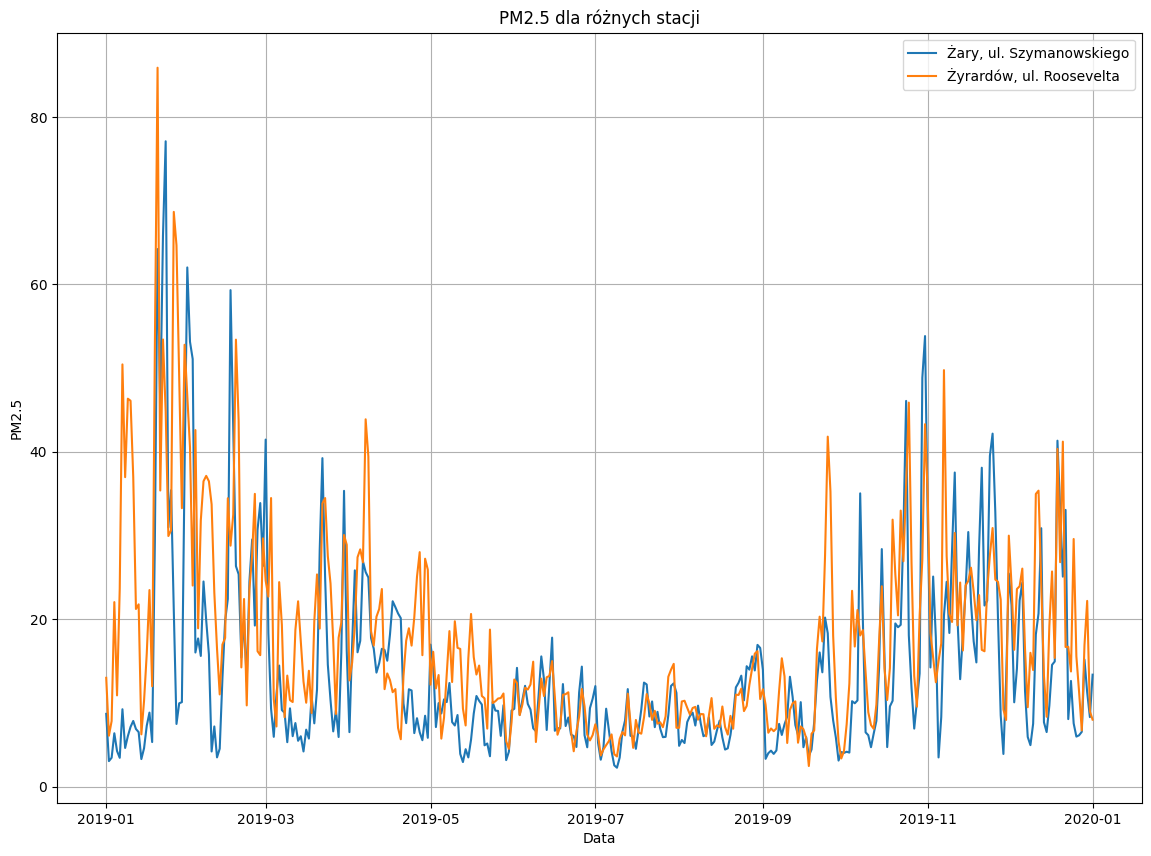

In [27]:
station_groups = [daily_avg_pm25['Nazwa stacji'].unique()[i:i+5] for i in range(0, len(daily_avg_pm25['Nazwa stacji'].unique()), 5)]

for group in station_groups:
    group_data = daily_avg_pm25[daily_avg_pm25['Nazwa stacji'].isin(group)]
    plt.figure(figsize=(14, 10))
    for station in group:
        station_data = group_data[group_data['Nazwa stacji'] == station]
        plt.plot(station_data['Data'], station_data['PM25'], label=station)
    plt.title("PM2.5 dla różnych stacji")
    plt.xlabel("Data")
    plt.ylabel("PM2.5")
    plt.legend()
    plt.grid(True)

Stworozno wykresy liniowe ukazujące rozkład wartości PM2.5 w czasie dla wszystkich stacji. Widoczna jest pewna analogia, która ukazuje wysokie wahania i wartości stężeń w miesiącach chłodnych oraz niższe wartosci i wahania w ciepłym okresie.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 [Text(0, 0, 'DOLNOŚLĄSKIE'),
  Text(1, 0, 'KUJAWSKO-POMORSKIE'),
  Text(2, 0, 'LUBELSKIE'),
  Text(3, 0, 'LUBUSKIE'),
  Text(4, 0, 'MAZOWIECKIE'),
  Text(5, 0, 'MAŁOPOLSKIE'),
  Text(6, 0, 'OPOLSKIE'),
  Text(7, 0, 'PODKARPACKIE'),
  Text(8, 0, 'PODLASKIE'),
  Text(9, 0, 'WARMIŃSKO-MAZURSKIE'),
  Text(10, 0, 'WIELKOPOLSKIE'),
  Text(11, 0, 'ZACHODNIOPOMORSKIE'),
  Text(12, 0, 'ŁÓDZKIE'),
  Text(13, 0, 'ŚLĄSKIE'),
  Text(14, 0, 'ŚWIĘTOKRZYSKIE')])

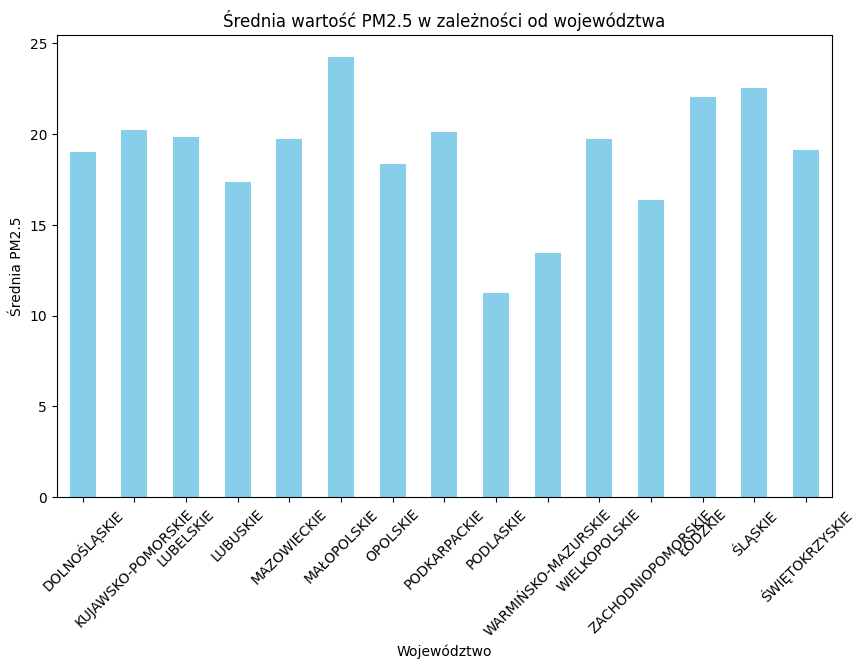

In [29]:
srednie_pm25 = data.groupby('Województwo')['PM25'].mean()
srednie_pm25.plot(kind='bar', figsize=(10, 6), color='skyblue')
plt.title('Średnia wartość PM2.5 w zależności od województwa')
plt.xlabel('Województwo')
plt.ylabel('Średnia PM2.5')
plt.xticks(rotation=45)

Średnie wartości dzienne w zależnosci od województwa są dosyć podobne. Wyrózniają się województwa podleskie oraz warmińsko-mazurskie (wartości najniższe) oraz mazowieckie (najwyższa wartość). Pozostałe rozkłądają się w przedziale średniej wartości 15-22. 

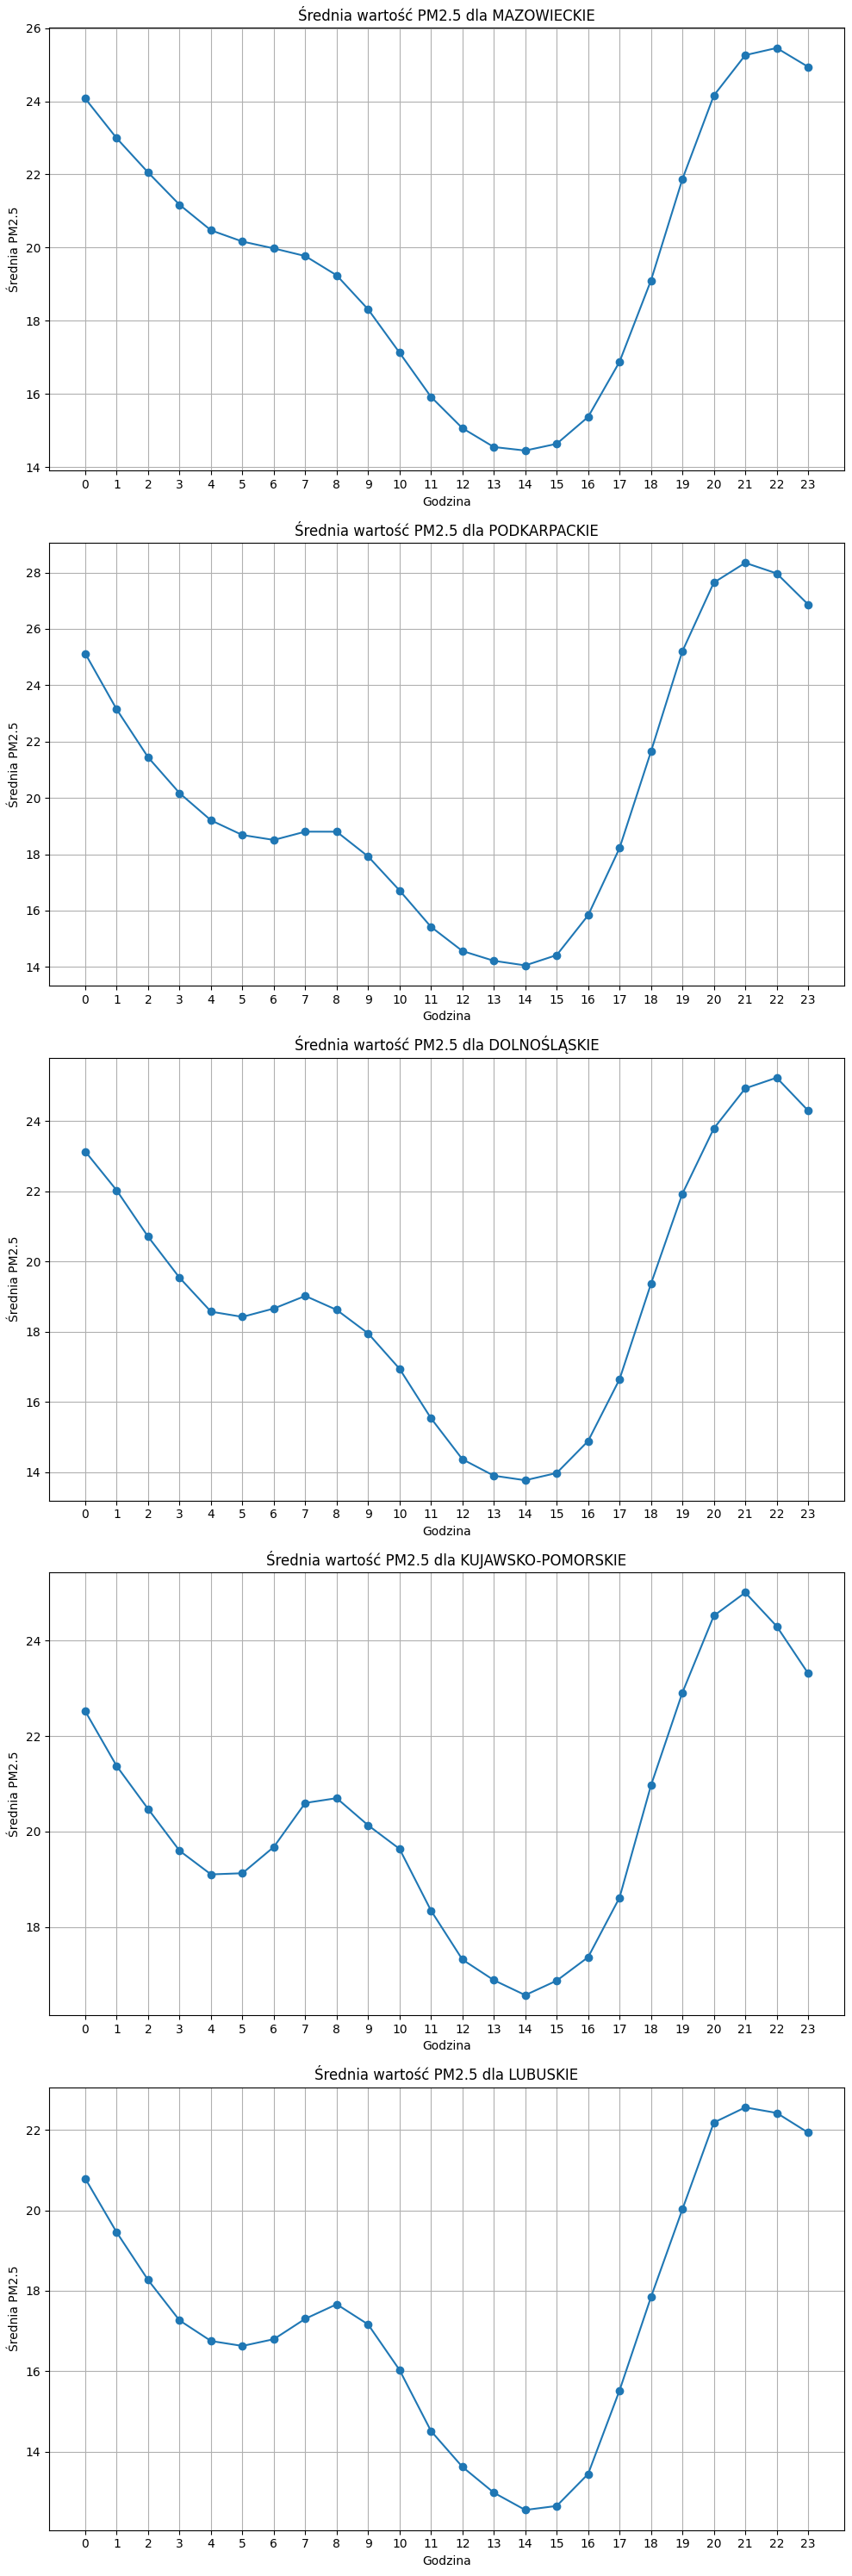

In [31]:
top_wojewodztwa = data['Województwo'].value_counts().nlargest(5).index.tolist()
dane_top = data[data['Województwo'].isin(top_wojewodztwa)]

fig, axes = plt.subplots(nrows=len(top_wojewodztwa), ncols=1, figsize=(10, 6 * len(top_wojewodztwa)))

for i, wojewodztwo in enumerate(top_wojewodztwa):
    dane_wojewodztwo = dane_top[dane_top['Województwo'] == wojewodztwo]
    srednie_pm25 = dane_wojewodztwo.groupby(dane_wojewodztwo.index.hour)['PM25'].mean()
    srednie_pm25.plot(ax=axes[i], kind='line', marker='o', linestyle='-')
    axes[i].set_title(f'Średnia wartość PM2.5 dla {wojewodztwo}')
    axes[i].set_xlabel('Godzina')
    axes[i].set_ylabel('Średnia PM2.5')
    axes[i].set_xticks(range(24))
    axes[i].grid(True)

plt.tight_layout()

Następnie sprawdzono rozkład wartości w ciągu dnia dla pięciu najczęściej badanych województw.

C:\Users\Kowalski Krzysztof\AppData\Local\Temp\ipykernel_13264\1185333966.py:1: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data = data.interpolate(method='linear').dropna(axis = 1)


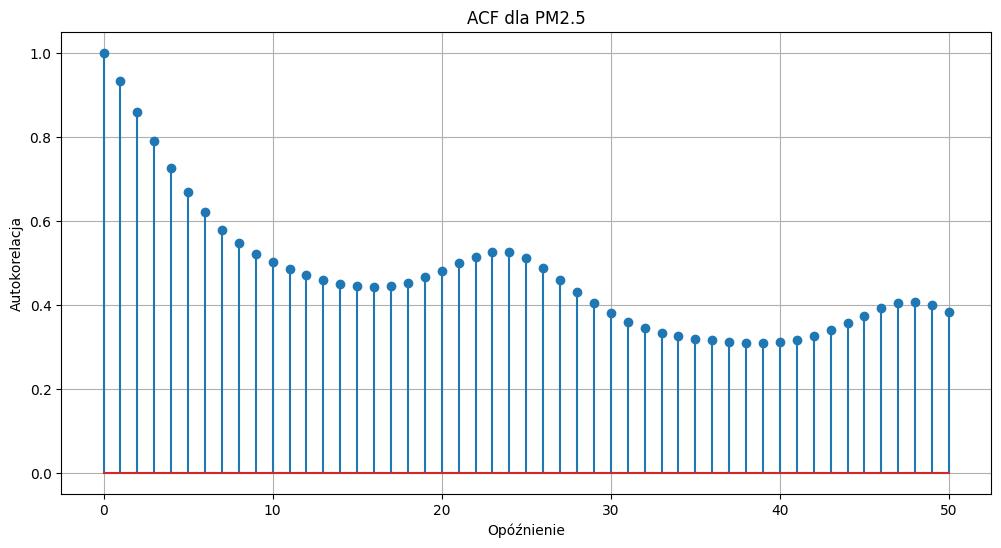

In [33]:
data = data.interpolate(method='linear').dropna(axis = 1)
data.isna().sum()
fig, ax = plt.subplots(figsize=(12, 6))
acf = sm.tsa.acf(data['PM25'], nlags = 50)
plt.stem(range(len(acf)), acf)
plt.title(f'ACF dla PM2.5')
plt.xlabel('Opóźnienie')
plt.ylabel('Autokorelacja')
plt.grid(True)

Bazując na wykresie autokorelacji widoczna jest cykliczność skoków podobieństwa co dzień (24 godziny).

#### Tworzenie kolumn związanych z data

Dodano 3 kolumny związane z datą: dzień tygodnia (poniedziałek = 0, niedziela = 6), miesiąć oraz rok.

In [37]:
data['Day_of_week'] = data.index.dayofweek  
data['Month'] = data.index.month
data['Year'] = data.index.year
data

Nazwa stacji      PM25 Typ obszaru  \
Data                                                                 
2019-01-01 01:00:00           Duszniki-Zdrój  33.40530     miejski   
2019-01-01 02:00:00           Duszniki-Zdrój  13.80280     miejski   
2019-01-01 03:00:00           Duszniki-Zdrój   9.94056     miejski   
2019-01-01 04:00:00           Duszniki-Zdrój   6.75889     miejski   
2019-01-01 05:00:00           Duszniki-Zdrój   7.88722     miejski   
...                                      ...       ...         ...   
2019-12-31 20:00:00  Szczecin_Budzysza Wosia  15.59590     miejski   
2019-12-31 21:00:00  Szczecin_Budzysza Wosia  13.18250     miejski   
2019-12-31 22:00:00  Szczecin_Budzysza Wosia  14.37640     miejski   
2019-12-31 23:00:00  Szczecin_Budzysza Wosia  17.79410     miejski   
2020-01-01 00:00:00  Szczecin_Budzysza Wosia  20.86120     miejski   

                            Województwo  WGS84 φ N  WGS84 λ E  Day_of_week  \
Data                                                                         
2019-01-01 01:00:00        DOLNOŚLĄSKIE  50.402645  16.393319            1   
2019-01-01 02:00:00        DOLNOŚLĄSKIE  50.402645  16.393319            1   
2019-01-01 03:00:00        DOLNOŚLĄSKIE  50.402645  16.393319            1   
2019-01-01 04:00:00        DOLNOŚLĄSKIE  50.402645  16.393319            1   
2019-01-01 05:00:00        DOLNOŚLĄSKIE  50.402645  16.393319            1   
...                                 ...        ...        ...          ...   
2019-12-31 20:00:00  ZACHODNIOPOMORSKIE  53.446761  14.507294            1   
2019-12-31 21:00:00  ZACHODNIOPOMORSKIE  53.446761  14.507294            1   
2019-12-31 22:00:00  ZACHODNIOPOMORSKIE  53.446761  14.507294            1   
2019-12-31 23:00:00  ZACHODNIOPOMORSKIE  53.446761  14.507294            1   
2020-01-01 00:00:00  ZACHODNIOPOMORSKIE  53.446761  14.507294            2   

                     Month  Year  
Data                              
2019-01-01 01:00:00      1  2019  
2019-01-01 02:00:00      1  2019  
2019-01-01 03:00:00      1  2019  
2019-01-01 04:00:00      1  2019  
2019-01-01 05:00:00      1  2019  
...                    ...   ...  
2019-12-31 20:00:00     12  2019  
2019-12-31 21:00:00     12  2019  
2019-12-31 22:00:00     12  2019  
2019-12-31 23:00:00     12  2019  
2020-01-01 00:00:00      1  2020  

[499320 rows x 9 columns]

#### Tworzenie kolumn bazując na średniej kroczącej i opoznieniach 

<Axes: xlabel='Data', ylabel='PM25'>

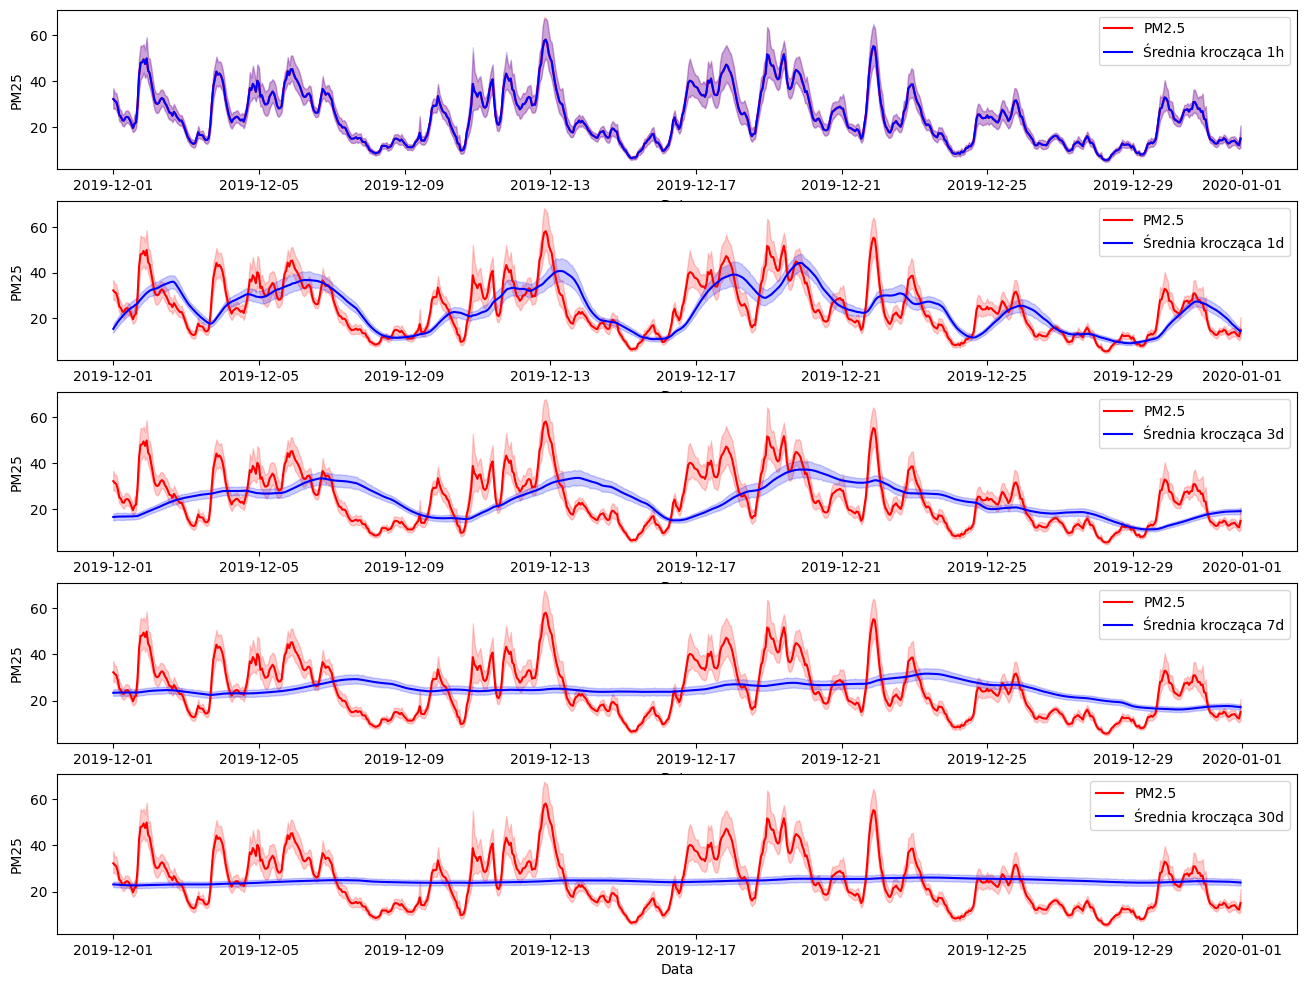

In [39]:
data['1h_SR_K'] = data.groupby('Nazwa stacji')['PM25'].rolling(window=1, min_periods=1).mean().reset_index(level=0, drop=True)
data['1d_SR_K'] = data.groupby('Nazwa stacji')['PM25'].rolling(window=24, min_periods=1).mean().reset_index(level=0, drop=True)
data['3d_SR_K'] = data.groupby('Nazwa stacji')['PM25'].rolling(window=24 * 3, min_periods=1).mean().reset_index(level=0, drop=True)
data['7d_SR_K'] = data.groupby('Nazwa stacji')['PM25'].rolling(window=24 * 7, min_periods=1).mean().reset_index(level=0, drop=True)
data['30d_SR_K'] = data.groupby('Nazwa stacji')['PM25'].rolling(window=24 * 30, min_periods=1).mean().reset_index(level=0, drop=True)

data_fragment = data[(data.index.month == 12)]

fig, axes = plt.subplots(5, 1, figsize = [16, 12])
sns.lineplot(data_fragment, x = data_fragment.index, y = data_fragment['PM25'], color = 'red', label = 'PM2.5', ax = axes[0])
sns.lineplot(data_fragment, x = data_fragment.index, y = data_fragment['1h_SR_K'], color = 'blue', label = 'Średnia krocząca 1h', ax = axes[0])

sns.lineplot(data_fragment, x = data_fragment.index, y = data_fragment['PM25'], color = 'red', label = 'PM2.5', ax = axes[1])
sns.lineplot(data_fragment, x = data_fragment.index, y = data_fragment['1d_SR_K'], color = 'blue', label = 'Średnia krocząca 1d', ax = axes[1])

sns.lineplot(data_fragment, x = data_fragment.index, y = data_fragment['PM25'], color = 'red', label = 'PM2.5', ax = axes[2])
sns.lineplot(data_fragment, x = data_fragment.index, y = data_fragment['3d_SR_K'], color = 'blue', label = 'Średnia krocząca 3d', ax = axes[2])

sns.lineplot(data_fragment, x = data_fragment.index, y = data_fragment['PM25'], color = 'red', label = 'PM2.5', ax = axes[3])
sns.lineplot(data_fragment, x = data_fragment.index, y = data_fragment['7d_SR_K'], color = 'blue', label = 'Średnia krocząca 7d', ax = axes[3])

sns.lineplot(data_fragment, x = data_fragment.index, y = data_fragment['PM25'], color = 'red', label = 'PM2.5', ax = axes[4])
sns.lineplot(data_fragment, x = data_fragment.index, y = data_fragment['30d_SR_K'], color = 'blue', label = 'Średnia krocząca 30d', ax = axes[4])

<Axes: xlabel='Data', ylabel='PM25'>

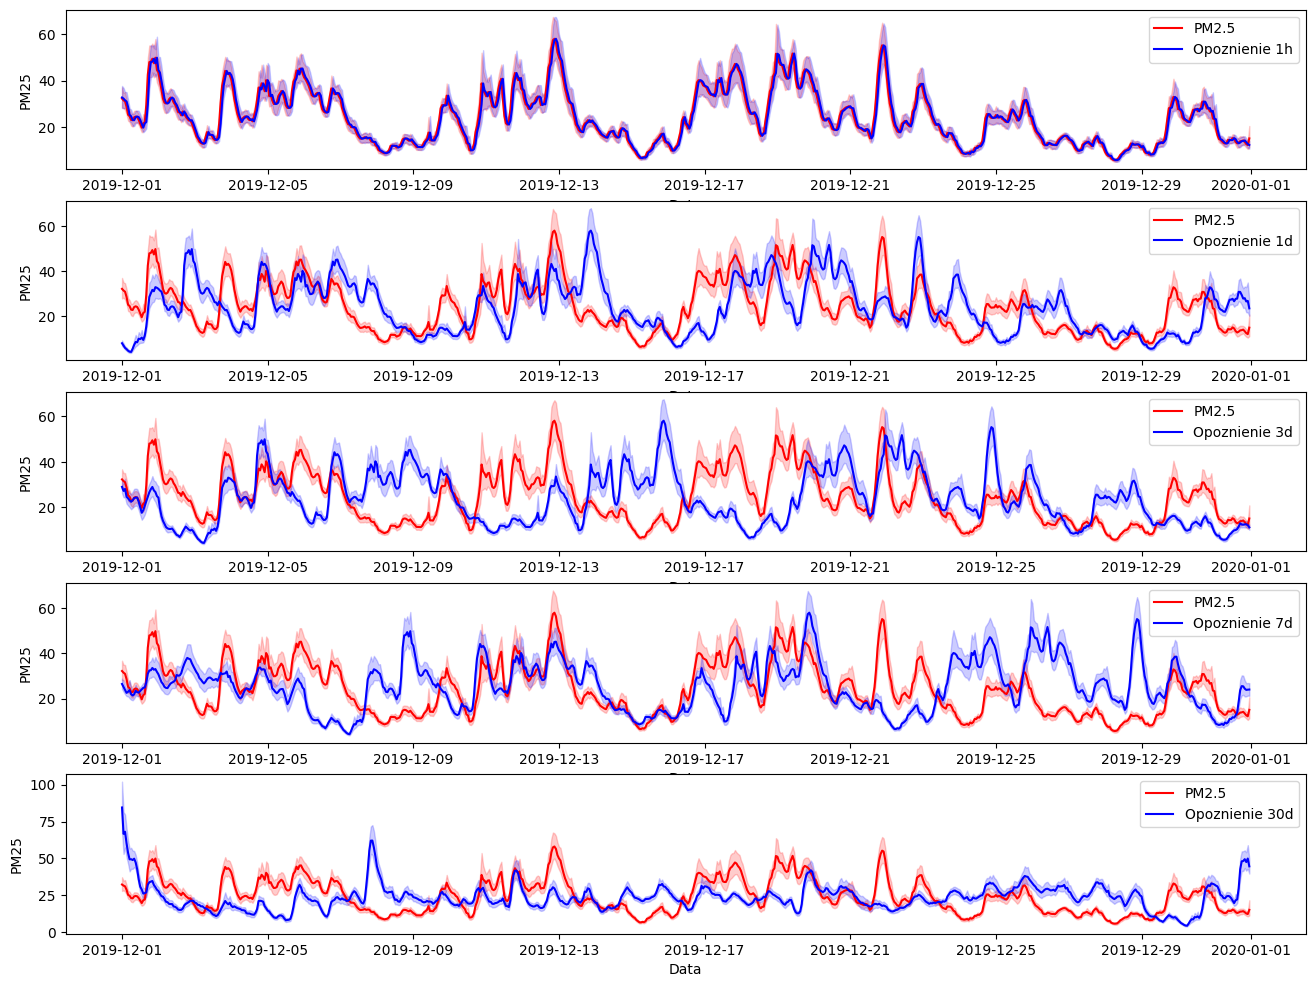

In [40]:
data['1h_OP'] = data.groupby('Nazwa stacji')['PM25'].shift(1)
data['1d_OP'] = data.groupby('Nazwa stacji')['PM25'].shift(24)
data['3d_OP'] = data.groupby('Nazwa stacji')['PM25'].shift(24 * 3)
data['7d_OP'] = data.groupby('Nazwa stacji')['PM25'].shift(24 * 7)
data['30d_OP'] = data.groupby('Nazwa stacji')['PM25'].shift(24 * 30)

data_fragment = data[(data.index.month == 12)]

fig, axes = plt.subplots(5, 1, figsize = [16, 12])
sns.lineplot(data_fragment, x = data_fragment.index, y = data_fragment['PM25'], color = 'red', label = 'PM2.5', ax = axes[0])
sns.lineplot(data_fragment, x = data_fragment.index, y = data_fragment['1h_OP'], color = 'blue', label = 'Opoznienie 1h', ax = axes[0])

sns.lineplot(data_fragment, x = data_fragment.index, y = data_fragment['PM25'], color = 'red', label = 'PM2.5', ax = axes[1])
sns.lineplot(data_fragment, x = data_fragment.index, y = data_fragment['1d_OP'], color = 'blue', label = 'Opoznienie 1d', ax = axes[1])

sns.lineplot(data_fragment, x = data_fragment.index, y = data_fragment['PM25'], color = 'red', label = 'PM2.5', ax = axes[2])
sns.lineplot(data_fragment, x = data_fragment.index, y = data_fragment['3d_OP'], color = 'blue', label = 'Opoznienie 3d', ax = axes[2])

sns.lineplot(data_fragment, x = data_fragment.index, y = data_fragment['PM25'], color = 'red', label = 'PM2.5', ax = axes[3])
sns.lineplot(data_fragment, x = data_fragment.index, y = data_fragment['7d_OP'], color = 'blue', label = 'Opoznienie 7d', ax = axes[3])

sns.lineplot(data_fragment, x = data_fragment.index, y = data_fragment['PM25'], color = 'red', label = 'PM2.5', ax = axes[4])
sns.lineplot(data_fragment, x = data_fragment.index, y = data_fragment['30d_OP'], color = 'blue', label = 'Opoznienie 30d', ax = axes[4])

### 2. Podział zbioru danych (5 punktów)
Podziel zbiór danych szeregów czasowych na zestawy treningowy i testowe, zachowując chronologię danych.

Pamiętaj, że posiadasz dane o charakterystyce czasowo-przestrzennej. 

Wykorzystaj ten podział do wstępnej oceny działania modelu. 

W celu podziału danych u względnieniem czasu przed podziałem posortowano dane oraz dokonano kategoryzacji danych innych niż liczbowe.

In [43]:
data.sort_index(inplace = True)

X = data.drop(columns=['PM25', '1h_SR_K'])  #'1h_OP'
y = data['PM25']  

encode_cols = ['Nazwa stacji', 'Typ obszaru', 'Województwo']

for col in encode_cols:
    labelencoder = LabelEncoder()
    X[col] = labelencoder.fit_transform(X[col])
X

Nazwa stacji  Typ obszaru  Województwo  WGS84 φ N  \
Data                                                                     
2019-01-01 01:00:00             4            0            0  50.402645   
2019-01-01 01:00:00            50            0           12  51.856692   
2019-01-01 01:00:00            32            0            7  50.040675   
2019-01-01 01:00:00            28            0            7  49.784339   
2019-01-01 01:00:00            48            0            3  51.799722   
...                           ...          ...          ...        ...   
2020-01-01 00:00:00            31            1            7  49.546539   
2020-01-01 00:00:00            53            0           12  51.758050   
2020-01-01 00:00:00            32            0            7  50.040675   
2020-01-01 00:00:00            13            0           14  50.878998   
2020-01-01 00:00:00            36            0           11  53.446761   

                     WGS84 λ E  Day_of_week  Month  Year    1d_SR_K  \
Data                                                                  
2019-01-01 01:00:00  16.393319            1      1  2019  13.000000   
2019-01-01 01:00:00  19.421231            1      1  2019  76.730600   
2019-01-01 01:00:00  22.004656            1      1  2019  42.034031   
2019-01-01 01:00:00  22.756239            1      1  2019  38.781605   
2019-01-01 01:00:00  16.317500            1      1  2019  64.075200   
...                        ...          ...    ...   ...        ...   
2020-01-01 00:00:00  21.851006            2      1  2020   9.960000   
2020-01-01 00:00:00  19.529786            2      1  2020  11.926698   
2020-01-01 00:00:00  22.004656            2      1  2020   9.446264   
2020-01-01 00:00:00  20.633692            2      1  2020  13.712149   
2020-01-01 00:00:00  14.507294            2      1  2020   8.566667   

                       3d_SR_K    7d_SR_K   30d_SR_K    1h_OP     1d_OP  \
Data                                                                      
2019-01-01 01:00:00  13.000000  13.000000  13.000000      NaN       NaN   
2019-01-01 01:00:00  76.730600  76.730600  76.730600      NaN       NaN   
2019-01-01 01:00:00  42.034031  42.034031  42.034031      NaN       NaN   
2019-01-01 01:00:00  38.781605  38.781605  38.781605      NaN       NaN   
2019-01-01 01:00:00  64.075200  64.075200  64.075200      NaN       NaN   
...                        ...        ...        ...      ...       ...   
2020-01-01 00:00:00  17.129028  15.910893  22.857958  13.6000  22.00000   
2020-01-01 00:00:00  29.433478  17.405045  25.337234   9.0000  21.00000   
2020-01-01 00:00:00  14.457141  13.033345  19.184583  15.2866  18.55700   
2020-01-01 00:00:00  17.139649  13.150660  23.136434   8.5700  25.56000   
2020-01-01 00:00:00  16.024861  15.851786  20.419736  17.7941   7.33104   

                        3d_OP    7d_OP   30d_OP  
Data                                             
2019-01-01 01:00:00       NaN      NaN      NaN  
2019-01-01 01:00:00       NaN      NaN      NaN  
2019-01-01 01:00:00       NaN      NaN      NaN  
2019-01-01 01:00:00       NaN      NaN      NaN  
2019-01-01 01:00:00       NaN      NaN      NaN  
...                       ...      ...      ...  
2020-01-01 00:00:00  13.60000   6.1000  17.4000  
2020-01-01 00:00:00   9.00000  44.0000  37.0000  
2020-01-01 00:00:00  29.71530  17.7406  15.9014  
2020-01-01 00:00:00   5.44000  20.7500  55.7900  
2020-01-01 00:00:00   9.37627  16.9329  18.6052  

[499320 rows x 17 columns]

Model z opóźnieniem 1h i średnią krocząca 1h - taki model osiągnie lepsze wyniki natomiast będzię nadawać się do przewidywania najbliższej przyszłości. Dane podzielono w sposób: 20% dane testowe oraz 80% dane treningowe.

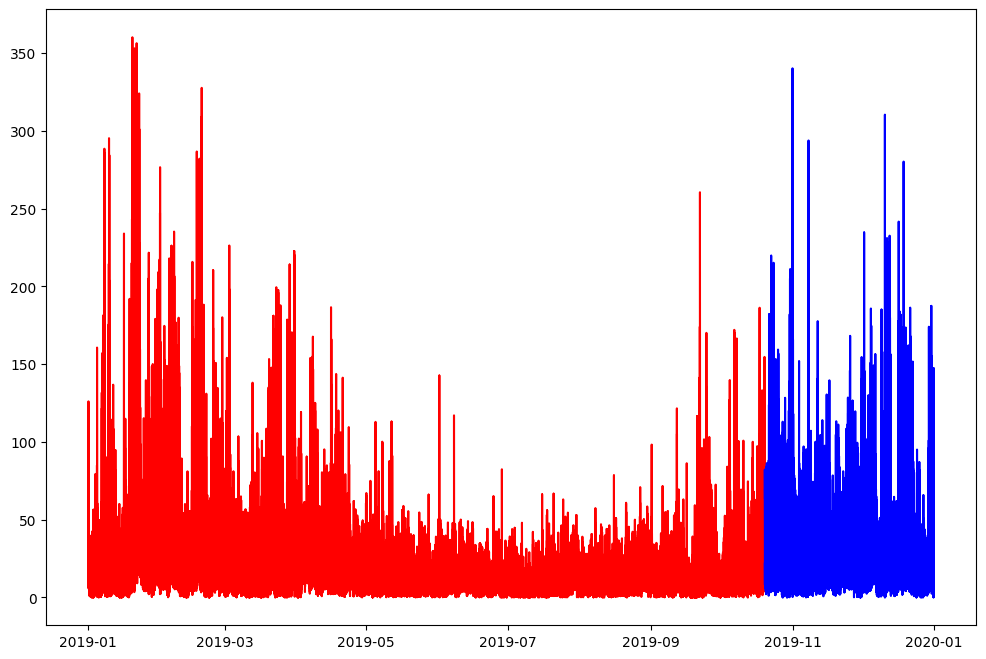

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, shuffle = False)

fig, axes = plt.subplots(1,1, figsize = [12, 8])
plt.plot(y_train, color = 'red')
plt.plot(y_test, color = 'blue')

## Część 2: Tworzenie modelu do predykcji (20 punktów)

### 1. Inicjalizacja i trenowanie modelu (10 punktów)
W tym ćwiczeniu do predykcji będziemy używaż algorytmu XGB (Extreme Gradient Boosting).

Zainicjuj i wytrenuj model na danych uczących. 

Napisz plusy i minusy wykorzystania tego algorytmu w kontekście predykcji szeregów czasowych w formie zwięzłej tabeli

XGB Boost plusy:
- posiada wysoką dokładność predykcji dzięki wykorzystywaniu skomplikowanych zależności nieliniowych,
- dane związane z szeregami czasowymi, często posiadają wartości brakujące, XGB Boost posiada wbudowane mechanizmy radzenia sobie z takimi wartościami,
- algorytm posiada techniki L1 i L2 (regularyzacji), które pozalajaą zapobiec przetrenowaniu się modelu (częsty bład w przypadku szeregów czasowych).

XGB Boost minusy:
- proces przygotowania danych i konfiguracji modelu może być czasochłonny i problematyczny,
- algorytm posiada wiele hiperparametrów, których wartość należy dostroić, aby zwiększych efekty,
- XGB Boost może być zasobobieżny, za równo pod kontem pamięci jak i złożoności obliczeniowej.

In [49]:
model = xgb.XGBRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print("Błąd średniokwadratowy (MSE):", mse)

r2 = r2_score(y_test, y_pred)
print("Współczynnik determinacji (R-squared):", r2)

Błąd średniokwadratowy (MSE): 77.01389925010608
Współczynnik determinacji (R-squared): 0.770628732017302


### 2. Tuning hiperparametrów (10 punktów)
Wykonaj tuning hiperparametrów poprzez trening i walidację krzyżową w celu znalezienia optymalnych wartości hiperparametrów.

Napisz  czym są hiperparametry i dlaczego wymagają tuningu. 

Hiperparametry to parametry algorytmu, które są ustawiane przed rozpoczęciem procesu uczenia maszynowego i które nie są optymalizowane podczas treningu modelu. Są to parametry, które kontrolują zachowanie algorytmu i strukturę modelu. Wpływają na jego wydajność i skuteczność. Tuning ich pozwala na lepsze dobranie ich co usprawni proces uczenia, a dzięki temu wynik całego działania algorytmu. Ponieważ algorytm XGB Boost posiada wiele hiperparametrów ich dostosowanie pozwoli osiągnąć lepsze wyniki dla badanego problemu.

In [52]:
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 200, 300]
}
grid_search = GridSearchCV(estimator=xgb.XGBRegressor(), param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

print("Najlepsze parametry:", grid_search.best_params_)
print("Najlepszy wynik:", grid_search.best_score_)

Najlepsze parametry: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Najlepszy wynik: -69.81401232093168


In [53]:
best_model = xgb.XGBRegressor(**grid_search.best_params_)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print("Błąd średniokwadratowy (MSE):", mse)

r2 = r2_score(y_test, y_pred)
print("Współczynnik determinacji (R-squared):", r2)

Błąd średniokwadratowy (MSE): 62.87115058269354
Współczynnik determinacji (R-squared): 0.812750222114436


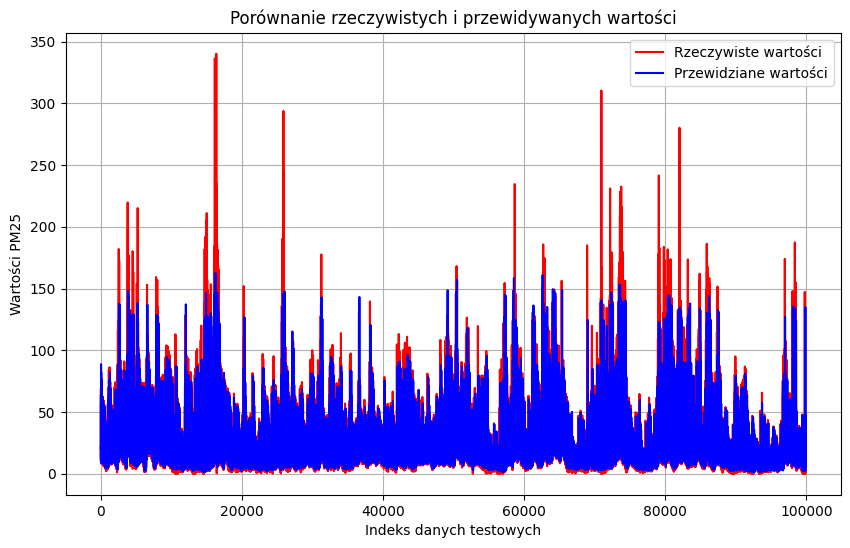

In [54]:
index = range(len(y_test))
plt.figure(figsize=(10, 6))
plt.plot(index, y_test, label='Rzeczywiste wartości', color='red')
plt.plot(index, y_pred, label='Przewidziane wartości', color='blue')
plt.xlabel('Indeks danych testowych')
plt.ylabel('Wartości PM25')
plt.title('Porównanie rzeczywistych i przewidywanych wartości')
plt.legend()
plt.grid(True)

## Część 3: Backtesting (20 punktów)


### 1. Podział na okna czasowe (10 punktów)
Podziel dane na wiele okien czasowych, na przykład poprzez użycie walk-forward lub roll-forward validation lub gap-roll-forward validation, aby uzyskać rzeczywistą ocenę wydajności modelu na przyszłych danych. 

Napisz na czym polega ten sposób walidacji i po co się go wykonuje. 

Walidacja na wielke okien czasowych jest kluczową techniką w modelowaniu szeregów czasowych. Zapewnia ona realistyczną ocenę modelu w kontekście zmieniających się danych. Polega ona na iteracyjnym trenowaniu i testowaniu modelu na różnych podzbiorach danych, przesuwając okno czasowe z każdą iteracją. Dzięki tej metodzie możemy lepiej zrozumieć, jak model radzi sobie w różnych warunkach czasowych i uniknąc błędów które mogą być powodowane przez tradycyje metody walidacji. 

In [58]:
tscv = TimeSeriesSplit(n_splits = 8)

### 2. Ocena wydajności (10 punktów)
Przeprowadź backtesting modelu, czyli ocenę wydajności modelu na danych historycznych, które nie zostały użyte do trenowania.

Czym rózni się backtesting od testowania wydajności modelu dla danych niebędących szeregami czasowymi? 

Główne różnice między backtestingiem, a testowaniem wydajności modelu dla danych niebędących szeragami czasowymi to?
- w backtestingu kolejność danych jest kluczowa i musi być zachowana, aby można było symulować przyszłe prognozy. W klasycznym kolejność danych nie ma znaczenia, a podziały mogą być losowe,
- backtesting odzwierdziedla rzeczywiste warunki pracy modelu w przyszłości, co lepiej sprawdza się w analizie szeregów czasowych,
- backtesting korzysta z przesuwających się okien czasowych (walk-forward, roll-forward lub gap-roll-forward validation), gdy klasycznie zazwyczaj korzysta się z metod losowego podziału takich jak crosswalidacja,
- dane czasowe possiadają naturalne zależności między kolejnymi obserwacjami, co musi być uwzgłędnione w procesie walidacji. W danych klasycznach obserwację są zazwyczaj niezależne.

In [61]:
mse_scores = []
r2_scores = []

model = xgb.XGBRegressor(**grid_search.best_params_)
for train_index, test_index in tscv.split(X_train):
    X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]
    
    model.fit(X_train_fold, y_train_fold)
    
    y_pred = model.predict(X_test_fold)
    
    mse = mean_squared_error(y_test_fold, y_pred)
    mse_scores.append(mse)
    
    r2 = r2_score(y_test_fold, y_pred)
    r2_scores.append(r2)

mean_mse = np.mean(mse_scores)
mean_r2 = np.mean(r2_scores)

print("Mean MSE:", mean_mse)
print("Mean R^2:", mean_r2)

Mean MSE: 29.682145150692634
Mean R^2: 0.8011858514966412


## Część 4: Analiza istotności cech (20 punktów)

### 1. Wyliczenie istotności cech (5 punktów)
Wykorzystaj wbudowane narzędzia do wyliczenia istotności cech w modelu (Feature Importance).

In [64]:
feature_importance = model.feature_importances_
columns = list(X_train.columns)
for i, importance in enumerate(feature_importance):
    print(f"Istotność cechy {columns[i]}: {importance}")

Istotność cechy Nazwa stacji: 0.03198323771357536
Istotność cechy Typ obszaru: 0.00031548592960461974
Istotność cechy Województwo: 0.007906577549874783
Istotność cechy WGS84 φ N: 0.002865417627617717
Istotność cechy WGS84 λ E: 0.0017405450344085693
Istotność cechy Day_of_week: 0.0017863311804831028
Istotność cechy Month: 0.016754381358623505
Istotność cechy Year: 0.0
Istotność cechy 1d_SR_K: 0.00785788893699646
Istotność cechy 3d_SR_K: 0.02538600005209446
Istotność cechy 7d_SR_K: 0.006205314304679632
Istotność cechy 30d_SR_K: 0.0019663472194224596
Istotność cechy 1h_OP: 0.853451132774353
Istotność cechy 1d_OP: 0.019817249849438667
Istotność cechy 3d_OP: 0.008371957577764988
Istotność cechy 7d_OP: 0.004258961882442236
Istotność cechy 30d_OP: 0.009333128109574318


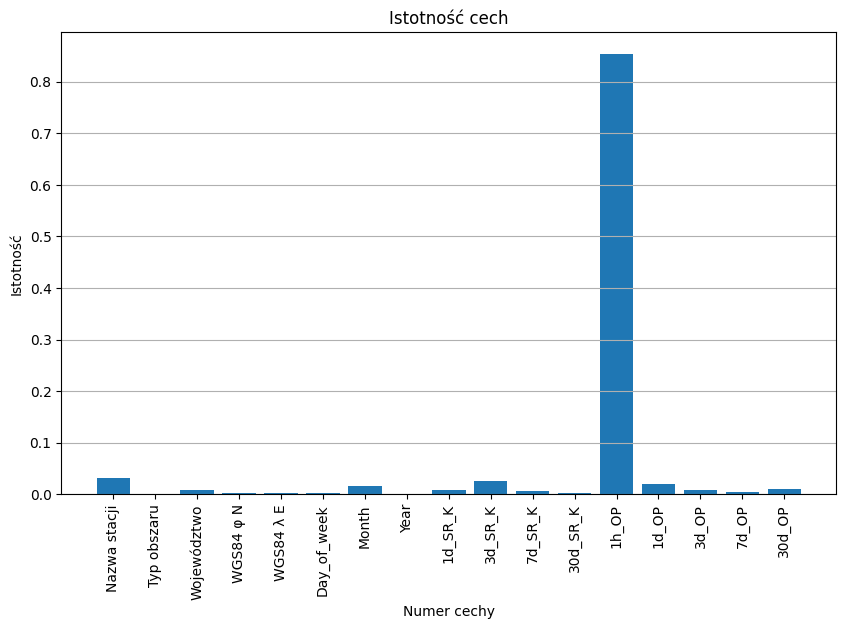

In [65]:
plt.figure(figsize=(10, 6))
plt.bar(columns, feature_importance)
plt.xlabel('Numer cechy')
plt.ylabel('Istotność')
plt.title('Istotność cech')
plt.xticks(columns, rotation = 90)
plt.grid(axis='y')

### 2. Interpretacja wyników (15 punktów)
Zinterpretuj istotność cech w kontekście dostępnych informacji - artykułów naukowych,  dokumentacji biblioteki itp.

W powyższym modelu posiadającym kolumne bazującą na opóznieniu wysokości 1h widoczny jest ogromny wpływ tej kolumny na działanie modelu. Bazując na otrzymanych wartościach metryk testowych model ten bardzo dobrze przewiduje wartości PM2.5. W celu próby stworzenia bardziej uniwersalnego modelu usunięto cechę ukazującą opóźnienie jednogodzinne.

In [68]:
data.sort_index(inplace = True)

X = data.drop(columns=['PM25', '1h_SR_K',  '1h_OP'])
y = data['PM25']  

encode_cols = ['Nazwa stacji', 'Typ obszaru', 'Województwo']

for col in encode_cols:
    labelencoder = LabelEncoder()
    X[col] = labelencoder.fit_transform(X[col])
X

Nazwa stacji  Typ obszaru  Województwo  WGS84 φ N  \
Data                                                                     
2019-01-01 01:00:00             4            0            0  50.402645   
2019-01-01 01:00:00            50            0           12  51.856692   
2019-01-01 01:00:00            32            0            7  50.040675   
2019-01-01 01:00:00            28            0            7  49.784339   
2019-01-01 01:00:00            48            0            3  51.799722   
...                           ...          ...          ...        ...   
2020-01-01 00:00:00            31            1            7  49.546539   
2020-01-01 00:00:00            53            0           12  51.758050   
2020-01-01 00:00:00            32            0            7  50.040675   
2020-01-01 00:00:00            13            0           14  50.878998   
2020-01-01 00:00:00            36            0           11  53.446761   

                     WGS84 λ E  Day_of_week  Month  Year    1d_SR_K  \
Data                                                                  
2019-01-01 01:00:00  16.393319            1      1  2019  13.000000   
2019-01-01 01:00:00  19.421231            1      1  2019  76.730600   
2019-01-01 01:00:00  22.004656            1      1  2019  42.034031   
2019-01-01 01:00:00  22.756239            1      1  2019  38.781605   
2019-01-01 01:00:00  16.317500            1      1  2019  64.075200   
...                        ...          ...    ...   ...        ...   
2020-01-01 00:00:00  21.851006            2      1  2020   9.960000   
2020-01-01 00:00:00  19.529786            2      1  2020  11.926698   
2020-01-01 00:00:00  22.004656            2      1  2020   9.446264   
2020-01-01 00:00:00  20.633692            2      1  2020  13.712149   
2020-01-01 00:00:00  14.507294            2      1  2020   8.566667   

                       3d_SR_K    7d_SR_K   30d_SR_K     1d_OP     3d_OP  \
Data                                                                       
2019-01-01 01:00:00  13.000000  13.000000  13.000000       NaN       NaN   
2019-01-01 01:00:00  76.730600  76.730600  76.730600       NaN       NaN   
2019-01-01 01:00:00  42.034031  42.034031  42.034031       NaN       NaN   
2019-01-01 01:00:00  38.781605  38.781605  38.781605       NaN       NaN   
2019-01-01 01:00:00  64.075200  64.075200  64.075200       NaN       NaN   
...                        ...        ...        ...       ...       ...   
2020-01-01 00:00:00  17.129028  15.910893  22.857958  22.00000  13.60000   
2020-01-01 00:00:00  29.433478  17.405045  25.337234  21.00000   9.00000   
2020-01-01 00:00:00  14.457141  13.033345  19.184583  18.55700  29.71530   
2020-01-01 00:00:00  17.139649  13.150660  23.136434  25.56000   5.44000   
2020-01-01 00:00:00  16.024861  15.851786  20.419736   7.33104   9.37627   

                       7d_OP   30d_OP  
Data                                   
2019-01-01 01:00:00      NaN      NaN  
2019-01-01 01:00:00      NaN      NaN  
2019-01-01 01:00:00      NaN      NaN  
2019-01-01 01:00:00      NaN      NaN  
2019-01-01 01:00:00      NaN      NaN  
...                      ...      ...  
2020-01-01 00:00:00   6.1000  17.4000  
2020-01-01 00:00:00  44.0000  37.0000  
2020-01-01 00:00:00  17.7406  15.9014  
2020-01-01 00:00:00  20.7500  55.7900  
2020-01-01 00:00:00  16.9329  18.6052  

[499320 rows x 16 columns]

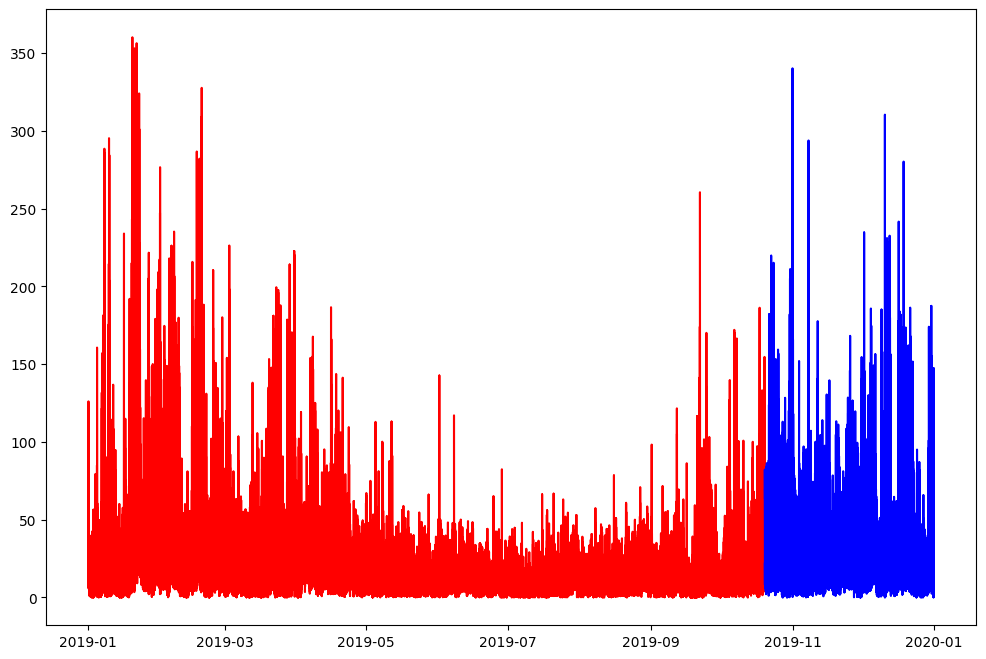

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle = False)

fig, axes = plt.subplots(1,1, figsize = [12, 8])
plt.plot(y_train, color = 'red')
plt.plot(y_test, color = 'blue')

In [70]:
model = xgb.XGBRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print("Błąd średniokwadratowy (MSE):", mse)

r2 = r2_score(y_test, y_pred)
print("Współczynnik determinacji (R-squared):", r2)

Błąd średniokwadratowy (MSE): 311.11213723639395
Współczynnik determinacji (R-squared): 0.07341160365126487


Bez tej cechy model posiada znacznie gorsze statystyki.

In [72]:
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 200, 300]
}
grid_search = GridSearchCV(estimator=xgb.XGBRegressor(), param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

print("Najlepsze parametry:", grid_search.best_params_)
print("Najlepszy wynik:", grid_search.best_score_)

Najlepsze parametry: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
Najlepszy wynik: -217.39854364121285


In [73]:
best_model = xgb.XGBRegressor(**grid_search.best_params_)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print("Błąd średniokwadratowy (MSE):", mse)

r2 = r2_score(y_test, y_pred)
print("Współczynnik determinacji (R-squared):", r2)

Błąd średniokwadratowy (MSE): 282.02101492499406
Współczynnik determinacji (R-squared): 0.16005398478737332


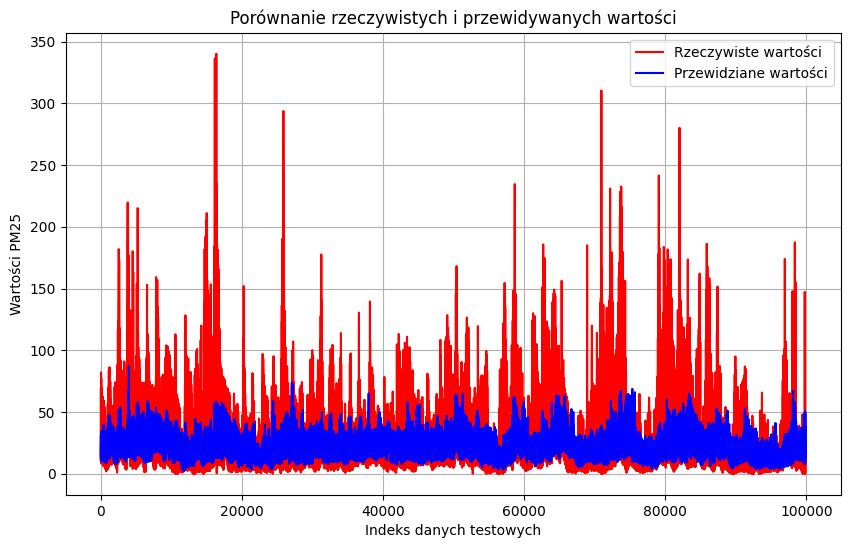

In [74]:
index = range(len(y_test))
plt.figure(figsize=(10, 6))
plt.plot(index, y_test, label='Rzeczywiste wartości', color='red')
plt.plot(index, y_pred, label='Przewidziane wartości', color='blue')
plt.xlabel('Indeks danych testowych')
plt.ylabel('Wartości PM25')
plt.title('Porównanie rzeczywistych i przewidywanych wartości')
plt.legend()
plt.grid(True)

In [75]:
tscv = TimeSeriesSplit(n_splits = 8)

In [76]:
mse_scores = []
r2_scores = []

model = xgb.XGBRegressor(**grid_search.best_params_)
for train_index, test_index in tscv.split(X_train):
    X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]
    
    model.fit(X_train_fold, y_train_fold)
    
    y_pred = model.predict(X_test_fold)
    
    mse = mean_squared_error(y_test_fold, y_pred)
    mse_scores.append(mse)
    
    r2 = r2_score(y_test_fold, y_pred)
    r2_scores.append(r2)

mean_mse = np.mean(mse_scores)
mean_r2 = np.mean(r2_scores)

print("Mean MSE:", mean_mse)
print("Mean R^2:", mean_r2)

Mean MSE: 151.57003149244986
Mean R^2: 0.20378762897091302


In [77]:
feature_importance = model.feature_importances_
columns = list(X_train.columns)
for i, importance in enumerate(feature_importance):
    print(f"Istotność cechy {columns[i]}: {importance}")

Istotność cechy Nazwa stacji: 0.04847313091158867
Istotność cechy Typ obszaru: 0.045297861099243164
Istotność cechy Województwo: 0.015866482630372047
Istotność cechy WGS84 φ N: 0.05105580762028694
Istotność cechy WGS84 λ E: 0.027293642982840538
Istotność cechy Day_of_week: 0.03461988642811775
Istotność cechy Month: 0.06915411353111267
Istotność cechy Year: 0.0
Istotność cechy 1d_SR_K: 0.23705363273620605
Istotność cechy 3d_SR_K: 0.013916288502514362
Istotność cechy 7d_SR_K: 0.03167867660522461
Istotność cechy 30d_SR_K: 0.019020305946469307
Istotność cechy 1d_OP: 0.29580432176589966
Istotność cechy 3d_OP: 0.039913661777973175
Istotność cechy 7d_OP: 0.03651047870516777
Istotność cechy 30d_OP: 0.03434166684746742


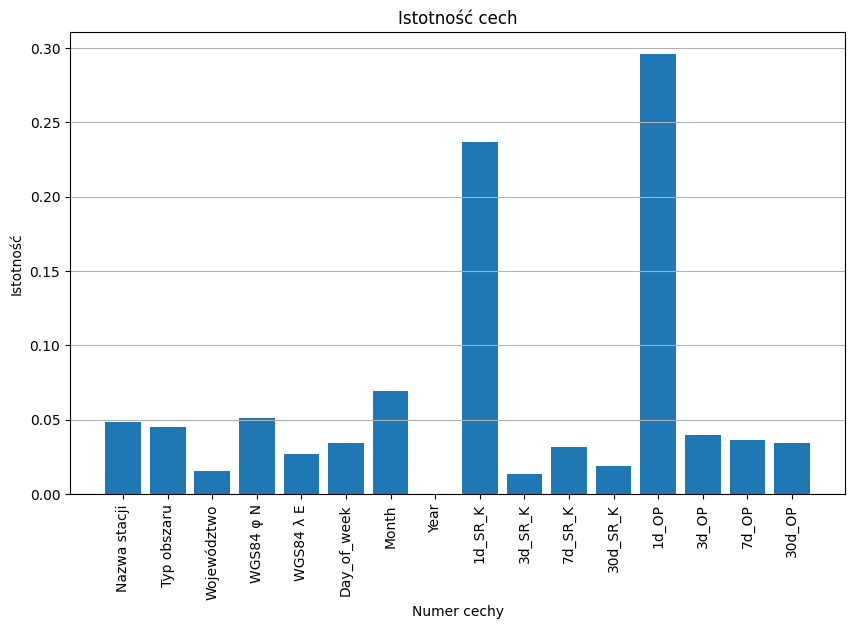

In [78]:
plt.figure(figsize=(10, 6))
plt.bar(columns, feature_importance)
plt.xlabel('Numer cechy')
plt.ylabel('Istotność')
plt.title('Istotność cech')
plt.xticks(columns, rotation = 90)
plt.grid(axis='y')

### WNIOSKI
- W danych widoczna była dzienna zzmienność danych - wartości zanieczyszczenia PM2.5 w ciągu dnia są wysokie w godzinach nocnych, dalej często występujące w Polsce piece (np. typu koza) wymagają wieczornego dorzucenia, aby utrzymać ciepło co widoczne jest w wykresie - wzrost wartości w godzinach, gdy ludzie zazwyczaj kładą się spać oraz delikatny pik po wstaniu (godzina 6-7). Podczas gdy większość osób jest wp pracy wartość stężenia jest niższa.
- Widoczny jest rónież wpływ temperatury powietrza (miesiące zimne, a ciepłe) na wielkość zanieczyszenia oraz wahania tej wielkości, co również może mieć związek z ogrzewaniem.
- Algorytm XGB Boost pozwala osiągać ciekawe i dobre wyniki działania na danych z czynnikiem czasowym.
- Tuning hiperparametrów pozwala dobrać je tak, aby końcowy model był jeszcze lepszy niż otrzymany.
- Backtesting jest ważny podczas walidacji modelu szeregu czasowego. Pozwala na przetestowanie go w różnych warunkach podobnych do rzeczywistych.
- Sprawdzenie istotności cech uwypukla ważność każdej z cech, co może pomóc wykryć błędne założenia lub wyciągnąc dodatkowe wnioski z danych.
- Stworzenie dwóch różnych modeli (jeden posiadający cechę z opóznieniem godzinowym) pozwoliło mi zwrócic uwagę jak dane te (o czym świadczył wykres autokorelacji, a po wykonaniu modelu wykres istotności cech) znacznie wpływają na model. Drugi z modeli bez tej cechy posiada wyrażnie gorsze zdolności predykcyjne i jest po prostu gorszym modelem, natomiast może on zostać wykorzystany do predykcji dalszych wartości w przyszłosci niż pierwszy ze stworzonych modeli. Co po raz kolejny pokazuje jak dobór i tworzenie cech ma znaczoncy wpływ na końcowy wygląd modelu.
- Dane, które posiadają informacje o stężeniu zanieczyszczenia PM2.5 dobrze nadają się do testowania na nich metod predykcji szeregów czasowych oraz pozwalają osiągnąć dobre wyniki analizy. 

## Część ogólna (10 punktów)

### 1. Zgodność kodu z PEP-8 oraz elegancja kodu

### 2. Ogólna interpretacja wyników

### 3. Skuteczność i precyzja
Oceniając wyniki backtestingu, skup się na skuteczności i precyzji predykcji modelu.

### 4. Kreatywność i innowacyjność
Oceniając analizę istotności cech oraz tworząć cechy poszukaj kreatywnych i innowacyjnych sposobów działania.

### 5. Strona edytorska 
Do oceny przekaż tylko finalny kod oraz interpretację. Pamiętaj o staranności edytorskiej.

## Oddanie projektu w terminie określonym w systemie (10 punktów)